순환 신경망 모델은 순차적인 자료에서 규칙적인 패턴을 인식하거나 그 의미를 추론할 수 있다.<br>
순차적이라는 특성 때문에 간단한 레이어로도 다양한 형태의 모델을 구성할 수 있다.<br>
케라스에서 제공하는 순환 신경망 레이어 : SimpleRNN, GRU, LSTM이 있으나 주로 LSTM을 사용한다.

# 1. 긴 시퀀스를 기억할 수 있는 LSTM(Long Short-Term Memory units) 레이어
LSTM 레이어는 아래와 같이 간단히 사용할 수 있다.<br>
- 입력 형태
 
    LSTM(3, input_dim=1)
  
기본 인자 : <br>
1. 1번째 인자 : 메모리 셀의 개수
2. 2번째 인자 : 입력 속성 수

Dense 레이어 형태와 비슷하다.<br>
첫번째 인자인 메모리 셀의 개수는 기억용량 정도와 출력 형태를 결정짓는다. = Dense 레이어에서의 출력 뉴런 수와 비슷<br>
input_dim은 Dense 레이어와 같이 일반적으로 속성의 개수가 들어간다.<br>
    
    Dense(3, input_dim=1)
    
LSTM의 한 가지 인자에 대해 더 알아보겠다.<br>
 
    LSTM(3, input_dim=1, input_length=4)
    
- input_length : 시퀀스 데이터의 입력 길이

Dense와 LSTM 도식화 참고(p.146)<br>
LSTM는 Dense와 비교하면 뉴련들이 튀어나와 있다.<br>
input_length가 길다고 해서 각 입력마다 다른 가중치가 사용하는 것이 입력 길이 만큼 연결한 것이기 때문에 모두 동일한 가중치를 공유함.<br>

- 출력 형태 : return_sequences : 시퀀스 출력 여부

LSTM 레이어는 return_sequences 인자에 따라 마지막 시퀀스에서 한 번만 출력할 수 있고 가가 시퀀스에서 출력할 수 있다.<br>
Many to many 문제를 풀거나 LSTM 레이어를 여러 개로 쌓아 올릴 때는 return_sequences=True 옵션을 사용한다.<br>
return_sequences=True -> 출력값이 여러 개, return_sequences=False -> 출력값이 1개<br>

- 상태유지(stateful) 모드 : stateful : 상태 유지 여부

학습 샘플의 가장 마지막 상태가 다음 샘플 학습 시에 입력으로 전달 여부를 지정하는 것<br>
하나의 샘플은 4개의 시퀀스 입력이 있고 총 3개의 샘플 있을 때(p.148 참고)<br>
- stateful=True일 때 : 도출된 현재 상태의 가중치가 다음 샘플 학습 시의 초기 상태로 입력됨
- stateful=False일 때 : 도출된 현재 상태의 가중치가 다음 샘플 학습 시의 초기 상태로 입력되지 않음


# 2. 순환 신경망 모델 만들기

### 1. 시퀀스 데이터 준비
순환 신경망은 주로 자연어 처리에 많이 쓰인다. -> 문장 학습 예제가 일반적이다. 예제는 악보로 하겠다.<br>
악보 학습이 더 쉬운 이유는<br> 
- 음계가 문장보다 더 코드화하기 쉽다.
- 시계열 자료이다.
- 나온 결과를 악보로 볼 수 있다.
- 우리가 학습한 모델이 연주하는 곡을 들어볼 수 있기 때문이다.

여기서 예제는 나비야로 하겠다.

### 2. 데이터셋 생성
각 샘플은 4개의 입력 데이터와 1개의 라벨값으로 구성되어 있다.<br>
즉 1~4번째 열은 속성(feature)이고, 5번째 열은 클래스(class)를 나타낸다.<br>
이렇게 4개씩 구간을 보는 것을 **윈도우 크기**가 4라고 한다.<br>
문자와 숫자로 된 음표(코드)로는 모델 입출력으로 사용할 수 없기 때문에 각 코드를 숫자로 변환할 수 있는 사전을 만들어본다.<br>
첫번째 사전은 코드를 숫자로, 두번째 사전은 숫자를 코드로 만드는 코드입니다.<br>

In [1]:
code2idx = {'c4':0, 'd4':1, 'e4':2, 'f4':3, 'g4':4, 'a4':5, 'b4':6,
            'c8':7, 'd8':8, 'e8':9, 'f8':10, 'g8':11, 'a8':12, 'b8':13}

idx2code = {0:'c4', 1:'d4', 2:'e4', 3:'f4', 4:'g4', 5:'a4', 6:'b4',
            7:'c8', 8:'d8', 9:'e8', 10:'f8', 11:'g8', 12:'a8', 13:'b8'}

이러한 사전을 이용해서 순차적인 음표를 우리가 지정한 윈도우 크기만큼 잘라 데이터셋을 생성하는 함수를 정의해본다.

In [2]:
import numpy as np

def seq2dataset(seq, window_size):
    dataset = []
    for i in range(len(seq)-window_size):
        subset = seq[i:(i+window_size+1)]
        dataset.append([code2idx[item] for item in subset])
    return np.array(dataset)

seq라는 변수에 “나비야” 곡 전체 음표를 저장한 다음, seq2dataset() 함수를 하여 dataset를 생성한다.

In [3]:
seq = ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'd8', 'e8', 'f8', 'g8', 'g8', 'g4',
       'g8', 'e8', 'e8', 'e8', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4',
       'd8', 'd8', 'd8', 'd8', 'd8', 'e8', 'f4', 'e8', 'e8', 'e8', 'e8', 'e8', 'f8', 'g4',
       'g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4']

dataset = seq2dataset(seq, window_size = 4)

print(dataset.shape)
print(dataset)

(50, 5)
[[11  9  2 10  8]
 [ 9  2 10  8  1]
 [ 2 10  8  1  7]
 [10  8  1  7  8]
 [ 8  1  7  8  9]
 [ 1  7  8  9 10]
 [ 7  8  9 10 11]
 [ 8  9 10 11 11]
 [ 9 10 11 11  4]
 [10 11 11  4 11]
 [11 11  4 11  9]
 [11  4 11  9  9]
 [ 4 11  9  9  9]
 [11  9  9  9 10]
 [ 9  9  9 10  8]
 [ 9  9 10  8  1]
 [ 9 10  8  1  7]
 [10  8  1  7  9]
 [ 8  1  7  9 11]
 [ 1  7  9 11 11]
 [ 7  9 11 11  9]
 [ 9 11 11  9  9]
 [11 11  9  9  2]
 [11  9  9  2  8]
 [ 9  9  2  8  8]
 [ 9  2  8  8  8]
 [ 2  8  8  8  8]
 [ 8  8  8  8  8]
 [ 8  8  8  8  9]
 [ 8  8  8  9  3]
 [ 8  8  9  3  9]
 [ 8  9  3  9  9]
 [ 9  3  9  9  9]
 [ 3  9  9  9  9]
 [ 9  9  9  9  9]
 [ 9  9  9  9 10]
 [ 9  9  9 10  4]
 [ 9  9 10  4 11]
 [ 9 10  4 11  9]
 [10  4 11  9  2]
 [ 4 11  9  2 10]
 [11  9  2 10  8]
 [ 9  2 10  8  1]
 [ 2 10  8  1  7]
 [10  8  1  7  9]
 [ 8  1  7  9 11]
 [ 1  7  9 11 11]
 [ 7  9 11 11  9]
 [ 9 11 11  9  9]
 [11 11  9  9  2]]


### 3. 학습과정
첫 4개 음표를 입력하면 나머지를 연주할 수 있게 만드는 모델을 만드는 것이 목표이다.<br>
학습시키는 방식은 아래와 같다.<br>
- 1~4번째 음표를 데이터로, 5번째 음표를 라벨값으로 학습시킨다.
- 다음에는 2~5번째 음표를, 데이터로 6번째 음표를 라벨값으로 학습시킨다.
- 이후 한 음표씩 넘어가면서 노래를 끝까지 학습시킨다.

### 4. 예측 과정
- 한 스텝 예측
한 스텝 예측이란 실제 음표 4개를 입력하여 다음 음표 1개를 예측하는 과정을 반복하는 것이다.<br>
이 방법에서는 모델의 입력값으로는 항상 실제 음표가 들어간다.<br>
    - 모델에 t0,t1,t2,t3를 입력하면 y0 출력이 나온다.
    - 모델에 t1,t2,t3,t4를 입력하면 y1 출력이 나온다.
    - 모델에 t2,t3,t4,t5를 입력하면 y2 출력이 나온다.
    - 이 과정을 y49 출력까지 반복한다.
    
- 곡 전체 예측
곡 전체 예측이란 입력된 초가 4개 음표만을 입력으로 곡 전체를 예측하는 것이다.<br>
초반부가 지나면 예측값만으로 모델에 입력되어 다음 예측값이 나오는 식이다.<br>
그야말로 "나비야~ 나"까지 알려주면 나머지까지 모두 연주를 하는 것이다.<br>
만약 중간에 틀린 부분이 있다면, 이후 음정과 박자는 모두 이상하게 될 가능이 많다. 즉 예측 오류가 누적되는 것이다.<br>
    - 모델에 t0,t1,t2,t3를 입력하면 y0 출력이 나온다.
    - 예측값인 y0를 t4라고 가정하고, 모델에 t1,t2,t3,t4를 입력하면 y1 출력이 나온다.
    - 예측값인 y1를 t5라고 가정하고,모델에 t2,t3,t4(예측값),t5(예측값)를 입력하면 y2 출력이 나온다.
    - 이 과정을 y49 출력까지 반복한다.

### 5. 다층 퍼셉트론 신경망 모델
앞서 생성한 데이터셋으로 먼저 다층 퍼셉트론 모델을 학습시켜본다.<br>
 Dense 레이어 3개로 구성하였고, 입력 속성이 4개이고 출력이 12개(one_hot_vec_size=12)으로 설정했다.<br>

In [8]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
import numpy as np

one_hot_vec_size=12

model = Sequential()
model.add(Dense(128, input_dim=4, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(one_hot_vec_size, activation='softmax'))

전체 소스는 아래와 같다.

(50, 5)
[[11  9  2 10  8]
 [ 9  2 10  8  1]
 [ 2 10  8  1  7]
 [10  8  1  7  8]
 [ 8  1  7  8  9]
 [ 1  7  8  9 10]
 [ 7  8  9 10 11]
 [ 8  9 10 11 11]
 [ 9 10 11 11  4]
 [10 11 11  4 11]
 [11 11  4 11  9]
 [11  4 11  9  9]
 [ 4 11  9  9  9]
 [11  9  9  9 10]
 [ 9  9  9 10  8]
 [ 9  9 10  8  1]
 [ 9 10  8  1  7]
 [10  8  1  7  9]
 [ 8  1  7  9 11]
 [ 1  7  9 11 11]
 [ 7  9 11 11  9]
 [ 9 11 11  9  9]
 [11 11  9  9  2]
 [11  9  9  2  8]
 [ 9  9  2  8  8]
 [ 9  2  8  8  8]
 [ 2  8  8  8  8]
 [ 8  8  8  8  8]
 [ 8  8  8  8  9]
 [ 8  8  8  9  3]
 [ 8  8  9  3  9]
 [ 8  9  3  9  9]
 [ 9  3  9  9  9]
 [ 3  9  9  9  9]
 [ 9  9  9  9  9]
 [ 9  9  9  9 10]
 [ 9  9  9 10  4]
 [ 9  9 10  4 11]
 [ 9 10  4 11  9]
 [10  4 11  9  2]
 [ 4 11  9  2 10]
 [11  9  2 10  8]
 [ 9  2 10  8  1]
 [ 2 10  8  1  7]
 [10  8  1  7  9]
 [ 8  1  7  9 11]
 [ 1  7  9 11 11]
 [ 7  9 11 11  9]
 [ 9 11 11  9  9]
 [11 11  9  9  2]]
('one hot encoding vector size is ', 12)


Instructions for updating:
Use tf.where in 2.0, 

Epoch 101/2000
 - 0s - loss: 1.3975 - acc: 0.5200
Epoch 102/2000
 - 0s - loss: 1.3995 - acc: 0.5000
Epoch 103/2000
 - 0s - loss: 1.4000 - acc: 0.5000
Epoch 104/2000
 - 0s - loss: 1.3903 - acc: 0.5200
Epoch 105/2000
 - 0s - loss: 1.3863 - acc: 0.5200
Epoch 106/2000
 - 0s - loss: 1.3835 - acc: 0.5200
Epoch 107/2000
 - 0s - loss: 1.3877 - acc: 0.5000
Epoch 108/2000
 - 0s - loss: 1.3823 - acc: 0.5200
Epoch 109/2000
 - 0s - loss: 1.3851 - acc: 0.5000
Epoch 110/2000
 - 0s - loss: 1.3759 - acc: 0.5400
Epoch 111/2000
 - 0s - loss: 1.3775 - acc: 0.5200
Epoch 112/2000
 - 0s - loss: 1.3754 - acc: 0.5000
Epoch 113/2000
 - 0s - loss: 1.3770 - acc: 0.5000
Epoch 114/2000
 - 0s - loss: 1.3692 - acc: 0.5200
Epoch 115/2000
 - 0s - loss: 1.3634 - acc: 0.5200
Epoch 116/2000
 - 0s - loss: 1.3676 - acc: 0.5400
Epoch 117/2000
 - 0s - loss: 1.3563 - acc: 0.5400
Epoch 118/2000
 - 0s - loss: 1.3607 - acc: 0.5000
Epoch 119/2000
 - 0s - loss: 1.3550 - acc: 0.5200
Epoch 120/2000
 - 0s - loss: 1.3493 - acc: 0.5200


Epoch 265/2000
 - 0s - loss: 1.0758 - acc: 0.5800
Epoch 266/2000
 - 0s - loss: 1.0825 - acc: 0.5800
Epoch 267/2000
 - 0s - loss: 1.0708 - acc: 0.6000
Epoch 268/2000
 - 0s - loss: 1.0697 - acc: 0.5800
Epoch 269/2000
 - 0s - loss: 1.0704 - acc: 0.5800
Epoch 270/2000
 - 0s - loss: 1.0718 - acc: 0.5800
Epoch 271/2000
 - 0s - loss: 1.0662 - acc: 0.5800
Epoch 272/2000
 - 0s - loss: 1.0728 - acc: 0.5800
Epoch 273/2000
 - 0s - loss: 1.0656 - acc: 0.6000
Epoch 274/2000
 - 0s - loss: 1.0689 - acc: 0.5800
Epoch 275/2000
 - 0s - loss: 1.0691 - acc: 0.5800
Epoch 276/2000
 - 0s - loss: 1.0686 - acc: 0.5800
Epoch 277/2000
 - 0s - loss: 1.0601 - acc: 0.6000
Epoch 278/2000
 - 0s - loss: 1.0580 - acc: 0.5800
Epoch 279/2000
 - 0s - loss: 1.0590 - acc: 0.5800
Epoch 280/2000
 - 0s - loss: 1.0569 - acc: 0.5800
Epoch 281/2000
 - 0s - loss: 1.0521 - acc: 0.5800
Epoch 282/2000
 - 0s - loss: 1.0549 - acc: 0.5800
Epoch 283/2000
 - 0s - loss: 1.0572 - acc: 0.5800
Epoch 284/2000
 - 0s - loss: 1.0541 - acc: 0.6000


Epoch 429/2000
 - 0s - loss: 0.8939 - acc: 0.6800
Epoch 430/2000
 - 0s - loss: 0.8891 - acc: 0.6200
Epoch 431/2000
 - 0s - loss: 0.8928 - acc: 0.6400
Epoch 432/2000
 - 0s - loss: 0.8958 - acc: 0.6400
Epoch 433/2000
 - 0s - loss: 0.8922 - acc: 0.6800
Epoch 434/2000
 - 0s - loss: 0.8948 - acc: 0.6400
Epoch 435/2000
 - 0s - loss: 0.9051 - acc: 0.6400
Epoch 436/2000
 - 0s - loss: 0.8908 - acc: 0.6200
Epoch 437/2000
 - 0s - loss: 0.8863 - acc: 0.6800
Epoch 438/2000
 - 0s - loss: 0.8917 - acc: 0.6800
Epoch 439/2000
 - 0s - loss: 0.8887 - acc: 0.6600
Epoch 440/2000
 - 0s - loss: 0.8823 - acc: 0.6600
Epoch 441/2000
 - 0s - loss: 0.8902 - acc: 0.6400
Epoch 442/2000
 - 0s - loss: 0.8877 - acc: 0.6400
Epoch 443/2000
 - 0s - loss: 0.8861 - acc: 0.6800
Epoch 444/2000
 - 0s - loss: 0.8818 - acc: 0.6800
Epoch 445/2000
 - 0s - loss: 0.8835 - acc: 0.6600
Epoch 446/2000
 - 0s - loss: 0.8807 - acc: 0.6600
Epoch 447/2000
 - 0s - loss: 0.8803 - acc: 0.6600
Epoch 448/2000
 - 0s - loss: 0.8840 - acc: 0.6600


Epoch 593/2000
 - 0s - loss: 0.7547 - acc: 0.7400
Epoch 594/2000
 - 0s - loss: 0.7532 - acc: 0.7600
Epoch 595/2000
 - 0s - loss: 0.7558 - acc: 0.7000
Epoch 596/2000
 - 0s - loss: 0.7586 - acc: 0.7400
Epoch 597/2000
 - 0s - loss: 0.7507 - acc: 0.7400
Epoch 598/2000
 - 0s - loss: 0.7554 - acc: 0.7200
Epoch 599/2000
 - 0s - loss: 0.7576 - acc: 0.7000
Epoch 600/2000
 - 0s - loss: 0.7519 - acc: 0.7400
Epoch 601/2000
 - 0s - loss: 0.7515 - acc: 0.7200
Epoch 602/2000
 - 0s - loss: 0.7518 - acc: 0.7000
Epoch 603/2000
 - 0s - loss: 0.7479 - acc: 0.7200
Epoch 604/2000
 - 0s - loss: 0.7528 - acc: 0.7400
Epoch 605/2000
 - 0s - loss: 0.7469 - acc: 0.7400
Epoch 606/2000
 - 0s - loss: 0.7478 - acc: 0.7600
Epoch 607/2000
 - 0s - loss: 0.7600 - acc: 0.7200
Epoch 608/2000
 - 0s - loss: 0.7445 - acc: 0.7200
Epoch 609/2000
 - 0s - loss: 0.7444 - acc: 0.7000
Epoch 610/2000
 - 0s - loss: 0.7453 - acc: 0.7400
Epoch 611/2000
 - 0s - loss: 0.7472 - acc: 0.7400
Epoch 612/2000
 - 0s - loss: 0.7430 - acc: 0.7600


Epoch 757/2000
 - 0s - loss: 0.6642 - acc: 0.7400
Epoch 758/2000
 - 0s - loss: 0.6411 - acc: 0.8000
Epoch 759/2000
 - 0s - loss: 0.6432 - acc: 0.8000
Epoch 760/2000
 - 0s - loss: 0.6406 - acc: 0.8000
Epoch 761/2000
 - 0s - loss: 0.6390 - acc: 0.7400
Epoch 762/2000
 - 0s - loss: 0.6493 - acc: 0.7800
Epoch 763/2000
 - 0s - loss: 0.6404 - acc: 0.7800
Epoch 764/2000
 - 0s - loss: 0.6355 - acc: 0.7600
Epoch 765/2000
 - 0s - loss: 0.6396 - acc: 0.7800
Epoch 766/2000
 - 0s - loss: 0.6329 - acc: 0.8000
Epoch 767/2000
 - 0s - loss: 0.6320 - acc: 0.8000
Epoch 768/2000
 - 0s - loss: 0.6306 - acc: 0.8000
Epoch 769/2000
 - 0s - loss: 0.6297 - acc: 0.8000
Epoch 770/2000
 - 0s - loss: 0.6339 - acc: 0.8200
Epoch 771/2000
 - 0s - loss: 0.6238 - acc: 0.8000
Epoch 772/2000
 - 0s - loss: 0.6272 - acc: 0.7800
Epoch 773/2000
 - 0s - loss: 0.6263 - acc: 0.7800
Epoch 774/2000
 - 0s - loss: 0.6254 - acc: 0.8000
Epoch 775/2000
 - 0s - loss: 0.6283 - acc: 0.8000
Epoch 776/2000
 - 0s - loss: 0.6257 - acc: 0.7800


Epoch 921/2000
 - 0s - loss: 0.5410 - acc: 0.8000
Epoch 922/2000
 - 0s - loss: 0.5331 - acc: 0.8400
Epoch 923/2000
 - 0s - loss: 0.5313 - acc: 0.8200
Epoch 924/2000
 - 0s - loss: 0.5305 - acc: 0.8200
Epoch 925/2000
 - 0s - loss: 0.5327 - acc: 0.8200
Epoch 926/2000
 - 0s - loss: 0.5411 - acc: 0.7800
Epoch 927/2000
 - 0s - loss: 0.5253 - acc: 0.8200
Epoch 928/2000
 - 0s - loss: 0.5259 - acc: 0.8200
Epoch 929/2000
 - 0s - loss: 0.5224 - acc: 0.8600
Epoch 930/2000
 - 0s - loss: 0.5210 - acc: 0.8400
Epoch 931/2000
 - 0s - loss: 0.5196 - acc: 0.8200
Epoch 932/2000
 - 0s - loss: 0.5246 - acc: 0.8200
Epoch 933/2000
 - 0s - loss: 0.5176 - acc: 0.8200
Epoch 934/2000
 - 0s - loss: 0.5169 - acc: 0.8400
Epoch 935/2000
 - 0s - loss: 0.5206 - acc: 0.8400
Epoch 936/2000
 - 0s - loss: 0.5180 - acc: 0.8200
Epoch 937/2000
 - 0s - loss: 0.5178 - acc: 0.8400
Epoch 938/2000
 - 0s - loss: 0.5161 - acc: 0.8600
Epoch 939/2000
 - 0s - loss: 0.5193 - acc: 0.8200
Epoch 940/2000
 - 0s - loss: 0.5153 - acc: 0.8200


Epoch 1084/2000
 - 0s - loss: 0.4369 - acc: 0.8800
Epoch 1085/2000
 - 0s - loss: 0.4641 - acc: 0.8600
Epoch 1086/2000
 - 0s - loss: 0.4392 - acc: 0.9200
Epoch 1087/2000
 - 0s - loss: 0.4453 - acc: 0.9000
Epoch 1088/2000
 - 0s - loss: 0.4506 - acc: 0.8600
Epoch 1089/2000
 - 0s - loss: 0.4478 - acc: 0.8800
Epoch 1090/2000
 - 0s - loss: 0.4340 - acc: 0.9000
Epoch 1091/2000
 - 0s - loss: 0.4357 - acc: 0.8800
Epoch 1092/2000
 - 0s - loss: 0.4326 - acc: 0.9000
Epoch 1093/2000
 - 0s - loss: 0.4377 - acc: 0.9000
Epoch 1094/2000
 - 0s - loss: 0.4347 - acc: 0.9200
Epoch 1095/2000
 - 0s - loss: 0.4278 - acc: 0.9000
Epoch 1096/2000
 - 0s - loss: 0.4322 - acc: 0.9200
Epoch 1097/2000
 - 0s - loss: 0.4307 - acc: 0.9000
Epoch 1098/2000
 - 0s - loss: 0.4315 - acc: 0.9200
Epoch 1099/2000
 - 0s - loss: 0.4355 - acc: 0.9200
Epoch 1100/2000
 - 0s - loss: 0.4284 - acc: 0.9000
Epoch 1101/2000
 - 0s - loss: 0.4311 - acc: 0.8800
Epoch 1102/2000
 - 0s - loss: 0.4294 - acc: 0.8800
Epoch 1103/2000
 - 0s - loss: 0

Epoch 1245/2000
 - 0s - loss: 0.3660 - acc: 0.9200
Epoch 1246/2000
 - 0s - loss: 0.3711 - acc: 0.9200
Epoch 1247/2000
 - 0s - loss: 0.3688 - acc: 0.9200
Epoch 1248/2000
 - 0s - loss: 0.3710 - acc: 0.9200
Epoch 1249/2000
 - 0s - loss: 0.3690 - acc: 0.9200
Epoch 1250/2000
 - 0s - loss: 0.3715 - acc: 0.9200
Epoch 1251/2000
 - 0s - loss: 0.3751 - acc: 0.9000
Epoch 1252/2000
 - 0s - loss: 0.3707 - acc: 0.9200
Epoch 1253/2000
 - 0s - loss: 0.3651 - acc: 0.9200
Epoch 1254/2000
 - 0s - loss: 0.3658 - acc: 0.9200
Epoch 1255/2000
 - 0s - loss: 0.3703 - acc: 0.9200
Epoch 1256/2000
 - 0s - loss: 0.3624 - acc: 0.9200
Epoch 1257/2000
 - 0s - loss: 0.3736 - acc: 0.9200
Epoch 1258/2000
 - 0s - loss: 0.3637 - acc: 0.9200
Epoch 1259/2000
 - 0s - loss: 0.3681 - acc: 0.9200
Epoch 1260/2000
 - 0s - loss: 0.3641 - acc: 0.9200
Epoch 1261/2000
 - 0s - loss: 0.3745 - acc: 0.9000
Epoch 1262/2000
 - 0s - loss: 0.3673 - acc: 0.9200
Epoch 1263/2000
 - 0s - loss: 0.3673 - acc: 0.9200
Epoch 1264/2000
 - 0s - loss: 0

Epoch 1406/2000
 - 0s - loss: 0.3199 - acc: 0.9200
Epoch 1407/2000
 - 0s - loss: 0.3296 - acc: 0.9200
Epoch 1408/2000
 - 0s - loss: 0.3218 - acc: 0.9200
Epoch 1409/2000
 - 0s - loss: 0.3228 - acc: 0.9200
Epoch 1410/2000
 - 0s - loss: 0.3221 - acc: 0.9200
Epoch 1411/2000
 - 0s - loss: 0.3335 - acc: 0.9000
Epoch 1412/2000
 - 0s - loss: 0.3551 - acc: 0.9000
Epoch 1413/2000
 - 0s - loss: 0.3184 - acc: 0.9200
Epoch 1414/2000
 - 0s - loss: 0.3280 - acc: 0.9200
Epoch 1415/2000
 - 0s - loss: 0.3250 - acc: 0.9000
Epoch 1416/2000
 - 0s - loss: 0.3182 - acc: 0.9200
Epoch 1417/2000
 - 0s - loss: 0.3138 - acc: 0.9200
Epoch 1418/2000
 - 0s - loss: 0.3290 - acc: 0.9000
Epoch 1419/2000
 - 0s - loss: 0.3069 - acc: 0.9200
Epoch 1420/2000
 - 0s - loss: 0.3202 - acc: 0.9200
Epoch 1421/2000
 - 0s - loss: 0.3229 - acc: 0.9200
Epoch 1422/2000
 - 0s - loss: 0.3206 - acc: 0.9200
Epoch 1423/2000
 - 0s - loss: 0.3140 - acc: 0.9200
Epoch 1424/2000
 - 0s - loss: 0.3092 - acc: 0.9200
Epoch 1425/2000
 - 0s - loss: 0

Epoch 1567/2000
 - 0s - loss: 0.2786 - acc: 0.9200
Epoch 1568/2000
 - 0s - loss: 0.2824 - acc: 0.9200
Epoch 1569/2000
 - 0s - loss: 0.2798 - acc: 0.9200
Epoch 1570/2000
 - 0s - loss: 0.2801 - acc: 0.9200
Epoch 1571/2000
 - 0s - loss: 0.2813 - acc: 0.9200
Epoch 1572/2000
 - 0s - loss: 0.2844 - acc: 0.9200
Epoch 1573/2000
 - 0s - loss: 0.2766 - acc: 0.9200
Epoch 1574/2000
 - 0s - loss: 0.2930 - acc: 0.9200
Epoch 1575/2000
 - 0s - loss: 0.2881 - acc: 0.9000
Epoch 1576/2000
 - 0s - loss: 0.2854 - acc: 0.9200
Epoch 1577/2000
 - 0s - loss: 0.2741 - acc: 0.9200
Epoch 1578/2000
 - 0s - loss: 0.2836 - acc: 0.9200
Epoch 1579/2000
 - 0s - loss: 0.2762 - acc: 0.9200
Epoch 1580/2000
 - 0s - loss: 0.2764 - acc: 0.9200
Epoch 1581/2000
 - 0s - loss: 0.2724 - acc: 0.9200
Epoch 1582/2000
 - 0s - loss: 0.2812 - acc: 0.9200
Epoch 1583/2000
 - 0s - loss: 0.2771 - acc: 0.9200
Epoch 1584/2000
 - 0s - loss: 0.2747 - acc: 0.9200
Epoch 1585/2000
 - 0s - loss: 0.2762 - acc: 0.9200
Epoch 1586/2000
 - 0s - loss: 0

Epoch 1728/2000
 - 0s - loss: 0.2577 - acc: 0.9200
Epoch 1729/2000
 - 0s - loss: 0.2565 - acc: 0.9200
Epoch 1730/2000
 - 0s - loss: 0.2590 - acc: 0.9200
Epoch 1731/2000
 - 0s - loss: 0.2568 - acc: 0.9200
Epoch 1732/2000
 - 0s - loss: 0.2570 - acc: 0.9200
Epoch 1733/2000
 - 0s - loss: 0.2497 - acc: 0.9200
Epoch 1734/2000
 - 0s - loss: 0.2615 - acc: 0.9000
Epoch 1735/2000
 - 0s - loss: 0.2548 - acc: 0.9200
Epoch 1736/2000
 - 0s - loss: 0.2661 - acc: 0.9000
Epoch 1737/2000
 - 0s - loss: 0.2469 - acc: 0.9200
Epoch 1738/2000
 - 0s - loss: 0.2477 - acc: 0.9200
Epoch 1739/2000
 - 0s - loss: 0.2551 - acc: 0.9200
Epoch 1740/2000
 - 0s - loss: 0.2453 - acc: 0.9200
Epoch 1741/2000
 - 0s - loss: 0.2546 - acc: 0.9200
Epoch 1742/2000
 - 0s - loss: 0.2585 - acc: 0.9200
Epoch 1743/2000
 - 0s - loss: 0.2687 - acc: 0.9200
Epoch 1744/2000
 - 0s - loss: 0.2557 - acc: 0.9200
Epoch 1745/2000
 - 0s - loss: 0.2485 - acc: 0.9200
Epoch 1746/2000
 - 0s - loss: 0.2610 - acc: 0.9000
Epoch 1747/2000
 - 0s - loss: 0

Epoch 1889/2000
 - 0s - loss: 0.2326 - acc: 0.9200
Epoch 1890/2000
 - 0s - loss: 0.2351 - acc: 0.9200
Epoch 1891/2000
 - 0s - loss: 0.2356 - acc: 0.9200
Epoch 1892/2000
 - 0s - loss: 0.2292 - acc: 0.9200
Epoch 1893/2000
 - 0s - loss: 0.2240 - acc: 0.9200
Epoch 1894/2000
 - 0s - loss: 0.2344 - acc: 0.9000
Epoch 1895/2000
 - 0s - loss: 0.2246 - acc: 0.9200
Epoch 1896/2000
 - 0s - loss: 0.2471 - acc: 0.9200
Epoch 1897/2000
 - 0s - loss: 0.2375 - acc: 0.9200
Epoch 1898/2000
 - 0s - loss: 0.2378 - acc: 0.9000
Epoch 1899/2000
 - 0s - loss: 0.2306 - acc: 0.9200
Epoch 1900/2000
 - 0s - loss: 0.2294 - acc: 0.9200
Epoch 1901/2000
 - 0s - loss: 0.2315 - acc: 0.9200
Epoch 1902/2000
 - 0s - loss: 0.2324 - acc: 0.9200
Epoch 1903/2000
 - 0s - loss: 0.2358 - acc: 0.9000
Epoch 1904/2000
 - 0s - loss: 0.2271 - acc: 0.9200
Epoch 1905/2000
 - 0s - loss: 0.2330 - acc: 0.9200
Epoch 1906/2000
 - 0s - loss: 0.2392 - acc: 0.9200
Epoch 1907/2000
 - 0s - loss: 0.2398 - acc: 0.9000
Epoch 1908/2000
 - 0s - loss: 0

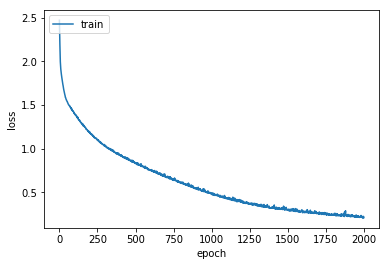

50/50 [==============================] - 0s 734us/step
acc: 92.00%
('one step prediction : ', ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'e8', 'f8', 'g8', 'g8', 'g4', 'g8', 'e8', 'e8', 'e8', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'f4', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'd8', 'g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4'])
('full song prediction : ', ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8'])


In [9]:
# 0. 사용할 패키지 불러오기
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
import numpy as np

# 랜덤시드 고정시키기
np.random.seed(5)

# 손실 이력 클래스 정의
class LossHistory(keras.callbacks.Callback):
    def init(self):
        self.losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        
# 데이터셋 생성 함수        
def seq2dataset(seq, window_size):
    dataset = []
    for i in range(len(seq)-window_size):
        subset = seq[i:(i+window_size+1)]
        dataset.append([code2idx[item] for item in subset])
    return np.array(dataset)


# 1. 데이터 준비하기

# 코드 사전 정의

code2idx = {'c4':0, 'd4':1, 'e4':2, 'f4':3, 'g4':4, 'a4':5, 'b4':6,
            'c8':7, 'd8':8, 'e8':9, 'f8':10, 'g8':11, 'a8':12, 'b8':13}

idx2code = {0:'c4', 1:'d4', 2:'e4', 3:'f4', 4:'g4', 5:'a4', 6:'b4',
            7:'c8', 8:'d8', 9:'e8', 10:'f8', 11:'g8', 12:'a8', 13:'b8'}

# 시퀀스 데이터 정의

seq = ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'd8', 'e8', 'f8', 'g8', 'g8', 'g4',
       'g8', 'e8', 'e8', 'e8', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4',
       'd8', 'd8', 'd8', 'd8', 'd8', 'e8', 'f4', 'e8', 'e8', 'e8', 'e8', 'e8', 'f8', 'g4',
       'g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4']

# 2. 데이터셋 생성하기
dataset = seq2dataset(seq, window_size = 4)

print(dataset.shape)
print(dataset)


# 입력(X)과 출력(Y) 변수로 분리하기
x_train = dataset[:,0:4]
y_train = dataset[:,4]

max_idx_value = 13

# 입력값 정규화 시키기
x_train = x_train / float(max_idx_value)

# 라벨값에 대한 one-hot 인코딩 수행
y_train = np_utils.to_categorical(y_train)

one_hot_vec_size = y_train.shape[1]

print("one hot encoding vector size is ", one_hot_vec_size)

# 3. 모델 구성하기
model = Sequential()
model.add(Dense(128, input_dim=4, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(one_hot_vec_size, activation='softmax'))

# 4. 모델 학습과정 설정하기
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = LossHistory() # 손실 이력 객체 생성
history.init()

# 5. 모델 학습시키기
model.fit(x_train, y_train, epochs=2000, batch_size=10, verbose=2, callbacks=[history])
    
# 6. 학습과정 살펴보기
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(history.losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

# 7. 모델 평가하기
scores = model.evaluate(x_train, y_train)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

# 8. 모델 사용하기

pred_count = 50 # 최대 예측 개수 정의

# 한 스텝 예측

seq_out = ['g8', 'e8', 'e4', 'f8']
pred_out = model.predict(x_train)

for i in range(pred_count):
    idx = np.argmax(pred_out[i]) # one-hot 인코딩들 중 최대값의 위치를 인덱스 값으로 변환
    seq_out.append(idx2code[idx]) # seq_out는 최종 악보이므로 인덱스 값을 코드로 변환하여 저장
    
print("one step prediction : ", seq_out)

# 곡 전체 예측

seq_in = ['g8', 'e8', 'e4', 'f8']
seq_out = seq_in
seq_in = [code2idx[it] / float(max_idx_value) for it in seq_in] # 코드를 인덱스값으로 변환(it이 정의 안되었는데 사용가능하나???)

for i in range(pred_count):
    sample_in = np.array(seq_in)
    sample_in = np.reshape(sample_in, (1, 4)) # batch_size, feature
    pred_out = model.predict(sample_in)
    idx = np.argmax(pred_out)
    seq_out.append(idx2code[idx])
    seq_in.append(idx / float(max_idx_value))
    seq_in.pop(0) # 0번째 배열 값 pop함

print("full song prediction : ", seq_out)

총 50개의 예측 중 4개를 틀려서 92% 정확도가 나왔다.<br>
중간에 틀린 부분이 생기면 곡 전체를 예측하는데 있어서 그리 좋은 성능이 나오지 않는다.

### 6. 기본 LSTM 모델
이번에는 간단한 기본 LSTM 모델로 테스트 해보겠다. 모델 구성은 다음과 같다.<br>
    - 128 메모리 셀을 가진 LSTM 레이어 1개와 Dense 레이어로 구성
    - 입력은 샘플 50개, 타임 스탭 4개, 속성 1개로 구성
    - 상태유지 모드 비활성화
    
    model = Sequential() 
    model.add(LSTM(128, input_shape = (4,1)))
    model.add(Dense(one_hot_vec_size, activation='softmax'))
    
LSTM을 제대로 활용하기 위해서는 **상태유지 모드, 배치사이즈, 타임스텝, 속성**에 대한 개념 이해가 필요하다.<br>
<br>
##### 타임스텝
하나의 샘플에 포함된 시퀀스 개수 -> 전체 코드에서 input_length와 동일<br>
현재 문제에서는 매 샘플마다 4개의 값을 입력하므로 타임스텝을 4개로 지정할 수 있다.<br>
즉 윈도우 크기와 동일하게 타임스텝으로 설정할 수 있다.<br>

#### 속성
뒤에서 더 자세히 설명하겠지만 지금은 대략 입력되는 음표 1개당 하나의 인덱스 값을 입력하므로 속성이 1개다.<br>
인자로는 input_shape = (4,1)과 input_dim = 1, input_length = 4와 동일하다.<br>
LSTM 모델에 따라 입력할 데이터셋도 샘플 수, 타임스텝 수, 속성 수 형식으로 맞추어야 한다.<br>

    x_train = np.reshape(x_train, (50, 4, 1)) # 샘플 수, 타임스텝 수, 속성 수
    
이 모델로 학습할 경우 다층 퍼셉트론 신경망 모델과 동일하게 4개의 음표를 입력으로 받고 그 다음 음표가 라벨값으로 지정한다.<br>
이 과정을 마칠 때까지 반복하게 된다.<br>
다층 퍼셉트론 모델에서는 **4개의 음표가 4개의 속성**으로 입력되고<br>
앞 신경망 모델과 **차이점**은 **LSTM**에서는 **4개의 음표가 4개의 시퀀스 입력**으로 들어간다. 여기서 **속성은 1개**이다.<br>
p. 160 사진참고

(50, 5)
[[11  9  2 10  8]
 [ 9  2 10  8  1]
 [ 2 10  8  1  7]
 [10  8  1  7  8]
 [ 8  1  7  8  9]
 [ 1  7  8  9 10]
 [ 7  8  9 10 11]
 [ 8  9 10 11 11]
 [ 9 10 11 11  4]
 [10 11 11  4 11]
 [11 11  4 11  9]
 [11  4 11  9  9]
 [ 4 11  9  9  9]
 [11  9  9  9 10]
 [ 9  9  9 10  8]
 [ 9  9 10  8  1]
 [ 9 10  8  1  7]
 [10  8  1  7  9]
 [ 8  1  7  9 11]
 [ 1  7  9 11 11]
 [ 7  9 11 11  9]
 [ 9 11 11  9  9]
 [11 11  9  9  2]
 [11  9  9  2  8]
 [ 9  9  2  8  8]
 [ 9  2  8  8  8]
 [ 2  8  8  8  8]
 [ 8  8  8  8  8]
 [ 8  8  8  8  9]
 [ 8  8  8  9  3]
 [ 8  8  9  3  9]
 [ 8  9  3  9  9]
 [ 9  3  9  9  9]
 [ 3  9  9  9  9]
 [ 9  9  9  9  9]
 [ 9  9  9  9 10]
 [ 9  9  9 10  4]
 [ 9  9 10  4 11]
 [ 9 10  4 11  9]
 [10  4 11  9  2]
 [ 4 11  9  2 10]
 [11  9  2 10  8]
 [ 9  2 10  8  1]
 [ 2 10  8  1  7]
 [10  8  1  7  9]
 [ 8  1  7  9 11]
 [ 1  7  9 11 11]
 [ 7  9 11 11  9]
 [ 9 11 11  9  9]
 [11 11  9  9  2]]
('one hot encoding vector size is ', 12)
Epoch 1/2000
 - 1s - loss: 2.4837 - acc: 0.1400
Ep

 - 0s - loss: 1.6223 - acc: 0.4400
Epoch 149/2000
 - 0s - loss: 1.6190 - acc: 0.4200
Epoch 150/2000
 - 0s - loss: 1.6245 - acc: 0.4200
Epoch 151/2000
 - 0s - loss: 1.6188 - acc: 0.4400
Epoch 152/2000
 - 0s - loss: 1.6410 - acc: 0.4000
Epoch 153/2000
 - 0s - loss: 1.6052 - acc: 0.4400
Epoch 154/2000
 - 0s - loss: 1.6341 - acc: 0.3800
Epoch 155/2000
 - 0s - loss: 1.6208 - acc: 0.4000
Epoch 156/2000
 - 0s - loss: 1.6171 - acc: 0.4200
Epoch 157/2000
 - 0s - loss: 1.6205 - acc: 0.3800
Epoch 158/2000
 - 0s - loss: 1.5934 - acc: 0.4400
Epoch 159/2000
 - 0s - loss: 1.6112 - acc: 0.4200
Epoch 160/2000
 - 0s - loss: 1.6027 - acc: 0.4200
Epoch 161/2000
 - 0s - loss: 1.5961 - acc: 0.4200
Epoch 162/2000
 - 0s - loss: 1.6023 - acc: 0.3800
Epoch 163/2000
 - 0s - loss: 1.6053 - acc: 0.4200
Epoch 164/2000
 - 0s - loss: 1.5869 - acc: 0.4400
Epoch 165/2000
 - 0s - loss: 1.5911 - acc: 0.4400
Epoch 166/2000
 - 0s - loss: 1.5884 - acc: 0.4400
Epoch 167/2000
 - 0s - loss: 1.5820 - acc: 0.4400
Epoch 168/2000


 - 0s - loss: 1.3094 - acc: 0.5200
Epoch 313/2000
 - 0s - loss: 1.2976 - acc: 0.5800
Epoch 314/2000
 - 0s - loss: 1.2973 - acc: 0.5600
Epoch 315/2000
 - 0s - loss: 1.2968 - acc: 0.5600
Epoch 316/2000
 - 0s - loss: 1.2963 - acc: 0.5600
Epoch 317/2000
 - 0s - loss: 1.2912 - acc: 0.5800
Epoch 318/2000
 - 0s - loss: 1.2957 - acc: 0.5600
Epoch 319/2000
 - 0s - loss: 1.3042 - acc: 0.5600
Epoch 320/2000
 - 0s - loss: 1.2939 - acc: 0.5600
Epoch 321/2000
 - 0s - loss: 1.2912 - acc: 0.5800
Epoch 322/2000
 - 0s - loss: 1.2782 - acc: 0.5600
Epoch 323/2000
 - 0s - loss: 1.2906 - acc: 0.5800
Epoch 324/2000
 - 0s - loss: 1.2804 - acc: 0.5400
Epoch 325/2000
 - 0s - loss: 1.2794 - acc: 0.5600
Epoch 326/2000
 - 0s - loss: 1.2787 - acc: 0.5800
Epoch 327/2000
 - 0s - loss: 1.2775 - acc: 0.5600
Epoch 328/2000
 - 0s - loss: 1.2793 - acc: 0.6000
Epoch 329/2000
 - 0s - loss: 1.3116 - acc: 0.5000
Epoch 330/2000
 - 0s - loss: 1.2979 - acc: 0.5200
Epoch 331/2000
 - 0s - loss: 1.2777 - acc: 0.5800
Epoch 332/2000


 - 0s - loss: 1.0388 - acc: 0.6200
Epoch 477/2000
 - 0s - loss: 1.0415 - acc: 0.6600
Epoch 478/2000
 - 0s - loss: 1.0347 - acc: 0.5800
Epoch 479/2000
 - 0s - loss: 1.0267 - acc: 0.5800
Epoch 480/2000
 - 0s - loss: 1.0329 - acc: 0.6200
Epoch 481/2000
 - 0s - loss: 1.0337 - acc: 0.6600
Epoch 482/2000
 - 0s - loss: 1.0332 - acc: 0.6000
Epoch 483/2000
 - 0s - loss: 1.0163 - acc: 0.6600
Epoch 484/2000
 - 0s - loss: 1.0202 - acc: 0.6000
Epoch 485/2000
 - 0s - loss: 1.0273 - acc: 0.6200
Epoch 486/2000
 - 0s - loss: 1.0315 - acc: 0.6000
Epoch 487/2000
 - 0s - loss: 1.0229 - acc: 0.6200
Epoch 488/2000
 - 0s - loss: 1.0160 - acc: 0.6200
Epoch 489/2000
 - 0s - loss: 1.0137 - acc: 0.6400
Epoch 490/2000
 - 0s - loss: 1.0158 - acc: 0.6000
Epoch 491/2000
 - 0s - loss: 1.0075 - acc: 0.6200
Epoch 492/2000
 - 0s - loss: 1.0008 - acc: 0.6000
Epoch 493/2000
 - 0s - loss: 1.0021 - acc: 0.6000
Epoch 494/2000
 - 0s - loss: 1.0019 - acc: 0.6000
Epoch 495/2000
 - 0s - loss: 1.0185 - acc: 0.6200
Epoch 496/2000


 - 0s - loss: 0.7663 - acc: 0.7000
Epoch 641/2000
 - 0s - loss: 0.7611 - acc: 0.7000
Epoch 642/2000
 - 0s - loss: 0.7621 - acc: 0.7200
Epoch 643/2000
 - 0s - loss: 0.7560 - acc: 0.7200
Epoch 644/2000
 - 0s - loss: 0.7811 - acc: 0.6600
Epoch 645/2000
 - 0s - loss: 0.7696 - acc: 0.6200
Epoch 646/2000
 - 0s - loss: 0.7775 - acc: 0.7200
Epoch 647/2000
 - 0s - loss: 0.8046 - acc: 0.7000
Epoch 648/2000
 - 0s - loss: 0.7670 - acc: 0.6600
Epoch 649/2000
 - 0s - loss: 0.7649 - acc: 0.7200
Epoch 650/2000
 - 0s - loss: 0.7493 - acc: 0.7400
Epoch 651/2000
 - 0s - loss: 0.7446 - acc: 0.7400
Epoch 652/2000
 - 0s - loss: 0.7490 - acc: 0.7000
Epoch 653/2000
 - 0s - loss: 0.7431 - acc: 0.7000
Epoch 654/2000
 - 0s - loss: 0.7575 - acc: 0.7200
Epoch 655/2000
 - 0s - loss: 0.7502 - acc: 0.7000
Epoch 656/2000
 - 0s - loss: 0.7422 - acc: 0.7200
Epoch 657/2000
 - 0s - loss: 0.7897 - acc: 0.7000
Epoch 658/2000
 - 0s - loss: 0.7453 - acc: 0.7200
Epoch 659/2000
 - 0s - loss: 0.7583 - acc: 0.6800
Epoch 660/2000


 - 0s - loss: 0.5632 - acc: 0.8400
Epoch 805/2000
 - 0s - loss: 0.5675 - acc: 0.8200
Epoch 806/2000
 - 0s - loss: 0.5693 - acc: 0.8200
Epoch 807/2000
 - 0s - loss: 0.5722 - acc: 0.8200
Epoch 808/2000
 - 0s - loss: 0.5686 - acc: 0.8200
Epoch 809/2000
 - 0s - loss: 0.5608 - acc: 0.8600
Epoch 810/2000
 - 0s - loss: 0.5622 - acc: 0.8200
Epoch 811/2000
 - 0s - loss: 0.5722 - acc: 0.8200
Epoch 812/2000
 - 0s - loss: 0.5653 - acc: 0.8000
Epoch 813/2000
 - 0s - loss: 0.5559 - acc: 0.8200
Epoch 814/2000
 - 0s - loss: 0.5621 - acc: 0.8000
Epoch 815/2000
 - 0s - loss: 0.5520 - acc: 0.8400
Epoch 816/2000
 - 0s - loss: 0.5588 - acc: 0.8000
Epoch 817/2000
 - 0s - loss: 0.5575 - acc: 0.8400
Epoch 818/2000
 - 0s - loss: 0.5671 - acc: 0.8400
Epoch 819/2000
 - 0s - loss: 0.6412 - acc: 0.7800
Epoch 820/2000
 - 0s - loss: 0.5674 - acc: 0.8000
Epoch 821/2000
 - 0s - loss: 0.6092 - acc: 0.7400
Epoch 822/2000
 - 0s - loss: 0.6246 - acc: 0.7600
Epoch 823/2000
 - 0s - loss: 0.5873 - acc: 0.8000
Epoch 824/2000


 - 0s - loss: 0.4655 - acc: 0.8400
Epoch 969/2000
 - 0s - loss: 0.4684 - acc: 0.8400
Epoch 970/2000
 - 0s - loss: 0.4750 - acc: 0.8600
Epoch 971/2000
 - 0s - loss: 0.4544 - acc: 0.9000
Epoch 972/2000
 - 0s - loss: 0.4837 - acc: 0.8400
Epoch 973/2000
 - 0s - loss: 0.4784 - acc: 0.8200
Epoch 974/2000
 - 0s - loss: 0.4645 - acc: 0.8400
Epoch 975/2000
 - 0s - loss: 0.4785 - acc: 0.8400
Epoch 976/2000
 - 0s - loss: 0.4700 - acc: 0.8800
Epoch 977/2000
 - 0s - loss: 0.4650 - acc: 0.8600
Epoch 978/2000
 - 0s - loss: 0.4714 - acc: 0.8200
Epoch 979/2000
 - 0s - loss: 0.4782 - acc: 0.8400
Epoch 980/2000
 - 0s - loss: 0.4790 - acc: 0.8400
Epoch 981/2000
 - 0s - loss: 0.4709 - acc: 0.8400
Epoch 982/2000
 - 0s - loss: 0.4587 - acc: 0.8400
Epoch 983/2000
 - 0s - loss: 0.4702 - acc: 0.8200
Epoch 984/2000
 - 0s - loss: 0.4667 - acc: 0.8400
Epoch 985/2000
 - 0s - loss: 0.4672 - acc: 0.8200
Epoch 986/2000
 - 0s - loss: 0.4831 - acc: 0.8400
Epoch 987/2000
 - 0s - loss: 0.4575 - acc: 0.8600
Epoch 988/2000


Epoch 1130/2000
 - 0s - loss: 0.4345 - acc: 0.8400
Epoch 1131/2000
 - 0s - loss: 0.4410 - acc: 0.8400
Epoch 1132/2000
 - 0s - loss: 0.4308 - acc: 0.8600
Epoch 1133/2000
 - 0s - loss: 0.4080 - acc: 0.8600
Epoch 1134/2000
 - 0s - loss: 0.4239 - acc: 0.8600
Epoch 1135/2000
 - 0s - loss: 0.4171 - acc: 0.8400
Epoch 1136/2000
 - 0s - loss: 0.4070 - acc: 0.8400
Epoch 1137/2000
 - 0s - loss: 0.4059 - acc: 0.8600
Epoch 1138/2000
 - 0s - loss: 0.4063 - acc: 0.8600
Epoch 1139/2000
 - 0s - loss: 0.4163 - acc: 0.8600
Epoch 1140/2000
 - 0s - loss: 0.4149 - acc: 0.8600
Epoch 1141/2000
 - 0s - loss: 0.4106 - acc: 0.8200
Epoch 1142/2000
 - 0s - loss: 0.4070 - acc: 0.8400
Epoch 1143/2000
 - 0s - loss: 0.4014 - acc: 0.8600
Epoch 1144/2000
 - 0s - loss: 0.4067 - acc: 0.8400
Epoch 1145/2000
 - 0s - loss: 0.4111 - acc: 0.8800
Epoch 1146/2000
 - 0s - loss: 0.4281 - acc: 0.8200
Epoch 1147/2000
 - 0s - loss: 0.3965 - acc: 0.8600
Epoch 1148/2000
 - 0s - loss: 0.4359 - acc: 0.8400
Epoch 1149/2000
 - 0s - loss: 0

Epoch 1291/2000
 - 0s - loss: 0.3714 - acc: 0.8400
Epoch 1292/2000
 - 0s - loss: 0.3764 - acc: 0.8800
Epoch 1293/2000
 - 0s - loss: 0.3548 - acc: 0.8800
Epoch 1294/2000
 - 0s - loss: 0.3769 - acc: 0.8600
Epoch 1295/2000
 - 0s - loss: 0.4053 - acc: 0.8400
Epoch 1296/2000
 - 0s - loss: 0.3850 - acc: 0.8800
Epoch 1297/2000
 - 0s - loss: 0.3883 - acc: 0.8600
Epoch 1298/2000
 - 0s - loss: 0.3692 - acc: 0.8600
Epoch 1299/2000
 - 0s - loss: 0.3990 - acc: 0.8600
Epoch 1300/2000
 - 0s - loss: 0.3646 - acc: 0.8600
Epoch 1301/2000
 - 0s - loss: 0.3750 - acc: 0.8600
Epoch 1302/2000
 - 0s - loss: 0.3763 - acc: 0.8600
Epoch 1303/2000
 - 0s - loss: 0.3703 - acc: 0.8600
Epoch 1304/2000
 - 0s - loss: 0.3603 - acc: 0.8600
Epoch 1305/2000
 - 0s - loss: 0.3673 - acc: 0.8800
Epoch 1306/2000
 - 0s - loss: 0.3793 - acc: 0.8400
Epoch 1307/2000
 - 0s - loss: 0.3691 - acc: 0.8600
Epoch 1308/2000
 - 0s - loss: 0.3873 - acc: 0.8400
Epoch 1309/2000
 - 0s - loss: 0.3671 - acc: 0.8600
Epoch 1310/2000
 - 0s - loss: 0

Epoch 1452/2000
 - 0s - loss: 0.3497 - acc: 0.8600
Epoch 1453/2000
 - 0s - loss: 0.4024 - acc: 0.8600
Epoch 1454/2000
 - 0s - loss: 0.3434 - acc: 0.8600
Epoch 1455/2000
 - 0s - loss: 0.3604 - acc: 0.8600
Epoch 1456/2000
 - 0s - loss: 0.3505 - acc: 0.8800
Epoch 1457/2000
 - 0s - loss: 0.3559 - acc: 0.8600
Epoch 1458/2000
 - 0s - loss: 0.3327 - acc: 0.8600
Epoch 1459/2000
 - 0s - loss: 0.3411 - acc: 0.8800
Epoch 1460/2000
 - 0s - loss: 0.3404 - acc: 0.8800
Epoch 1461/2000
 - 0s - loss: 0.3352 - acc: 0.8800
Epoch 1462/2000
 - 0s - loss: 0.3522 - acc: 0.8600
Epoch 1463/2000
 - 0s - loss: 0.3369 - acc: 0.8800
Epoch 1464/2000
 - 0s - loss: 0.3568 - acc: 0.8600
Epoch 1465/2000
 - 0s - loss: 0.3280 - acc: 0.8800
Epoch 1466/2000
 - 0s - loss: 0.3624 - acc: 0.8600
Epoch 1467/2000
 - 0s - loss: 0.3736 - acc: 0.8600
Epoch 1468/2000
 - 0s - loss: 0.3442 - acc: 0.8600
Epoch 1469/2000
 - 0s - loss: 0.4190 - acc: 0.8200
Epoch 1470/2000
 - 0s - loss: 0.3473 - acc: 0.8800
Epoch 1471/2000
 - 0s - loss: 0

Epoch 1613/2000
 - 0s - loss: 0.3370 - acc: 0.8800
Epoch 1614/2000
 - 0s - loss: 0.3290 - acc: 0.8600
Epoch 1615/2000
 - 0s - loss: 0.3414 - acc: 0.8800
Epoch 1616/2000
 - 0s - loss: 0.3328 - acc: 0.8600
Epoch 1617/2000
 - 0s - loss: 0.3381 - acc: 0.8600
Epoch 1618/2000
 - 0s - loss: 0.3343 - acc: 0.8800
Epoch 1619/2000
 - 0s - loss: 0.3207 - acc: 0.8600
Epoch 1620/2000
 - 0s - loss: 0.3263 - acc: 0.8600
Epoch 1621/2000
 - 0s - loss: 0.3252 - acc: 0.8600
Epoch 1622/2000
 - 0s - loss: 0.3159 - acc: 0.8600
Epoch 1623/2000
 - 0s - loss: 0.3159 - acc: 0.8400
Epoch 1624/2000
 - 0s - loss: 0.3303 - acc: 0.8600
Epoch 1625/2000
 - 0s - loss: 0.3228 - acc: 0.9000
Epoch 1626/2000
 - 0s - loss: 0.3297 - acc: 0.8800
Epoch 1627/2000
 - 0s - loss: 0.3139 - acc: 0.8800
Epoch 1628/2000
 - 0s - loss: 0.3231 - acc: 0.8800
Epoch 1629/2000
 - 0s - loss: 0.3148 - acc: 0.8800
Epoch 1630/2000
 - 0s - loss: 0.3275 - acc: 0.8600
Epoch 1631/2000
 - 0s - loss: 0.3211 - acc: 0.8800
Epoch 1632/2000
 - 0s - loss: 0

Epoch 1774/2000
 - 0s - loss: 0.3028 - acc: 0.8600
Epoch 1775/2000
 - 0s - loss: 0.3092 - acc: 0.8600
Epoch 1776/2000
 - 0s - loss: 0.2958 - acc: 0.8600
Epoch 1777/2000
 - 0s - loss: 0.3018 - acc: 0.8600
Epoch 1778/2000
 - 0s - loss: 0.2978 - acc: 0.8800
Epoch 1779/2000
 - 0s - loss: 0.3073 - acc: 0.8600
Epoch 1780/2000
 - 0s - loss: 0.3043 - acc: 0.8400
Epoch 1781/2000
 - 0s - loss: 0.2980 - acc: 0.8400
Epoch 1782/2000
 - 0s - loss: 0.3039 - acc: 0.8600
Epoch 1783/2000
 - 0s - loss: 0.3094 - acc: 0.8600
Epoch 1784/2000
 - 0s - loss: 0.3024 - acc: 0.8600
Epoch 1785/2000
 - 0s - loss: 0.3009 - acc: 0.8800
Epoch 1786/2000
 - 0s - loss: 0.3020 - acc: 0.8800
Epoch 1787/2000
 - 0s - loss: 0.2975 - acc: 0.8600
Epoch 1788/2000
 - 0s - loss: 0.2950 - acc: 0.8800
Epoch 1789/2000
 - 0s - loss: 0.2954 - acc: 0.8800
Epoch 1790/2000
 - 0s - loss: 0.3123 - acc: 0.8600
Epoch 1791/2000
 - 0s - loss: 0.2857 - acc: 0.8800
Epoch 1792/2000
 - 0s - loss: 0.3211 - acc: 0.8800
Epoch 1793/2000
 - 0s - loss: 0

Epoch 1935/2000
 - 0s - loss: 0.3013 - acc: 0.8600
Epoch 1936/2000
 - 0s - loss: 0.2915 - acc: 0.9000
Epoch 1937/2000
 - 0s - loss: 0.3067 - acc: 0.8800
Epoch 1938/2000
 - 0s - loss: 0.2906 - acc: 0.8800
Epoch 1939/2000
 - 0s - loss: 0.2871 - acc: 0.9000
Epoch 1940/2000
 - 0s - loss: 0.2924 - acc: 0.8600
Epoch 1941/2000
 - 0s - loss: 0.2862 - acc: 0.8600
Epoch 1942/2000
 - 0s - loss: 0.2874 - acc: 0.8800
Epoch 1943/2000
 - 0s - loss: 0.2851 - acc: 0.9000
Epoch 1944/2000
 - 0s - loss: 0.2878 - acc: 0.8600
Epoch 1945/2000
 - 0s - loss: 0.3032 - acc: 0.8800
Epoch 1946/2000
 - 0s - loss: 0.2926 - acc: 0.8800
Epoch 1947/2000
 - 0s - loss: 0.2930 - acc: 0.9000
Epoch 1948/2000
 - 0s - loss: 0.2912 - acc: 0.8600
Epoch 1949/2000
 - 0s - loss: 0.2990 - acc: 0.8600
Epoch 1950/2000
 - 0s - loss: 0.3023 - acc: 0.8600
Epoch 1951/2000
 - 0s - loss: 0.2838 - acc: 0.8600
Epoch 1952/2000
 - 0s - loss: 0.2999 - acc: 0.8800
Epoch 1953/2000
 - 0s - loss: 0.2863 - acc: 0.8800
Epoch 1954/2000
 - 0s - loss: 0

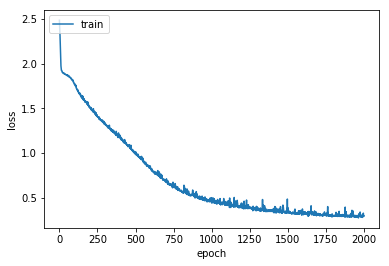

50/50 [==============================] - 0s 5ms/step
acc: 90.00%
('one step prediction : ', ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'f8', 'g8', 'g8', 'g4', 'g8', 'e8', 'e8', 'e8', 'f8', 'g4', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'f4', 'e8', 'e8', 'e8', 'e8', 'f8', 'f8', 'g4', 'g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4'])
('full song prediction : ', ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8'])


In [5]:
# 0. 사용할 패키지 불러오기
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.utils import np_utils
import numpy as np

# 랜덤시드 고정시키기
np.random.seed(5)

# 손실 이력 클래스 정의
class LossHistory(keras.callbacks.Callback):
    def init(self):
        self.losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        
# 데이터셋 생성 함수        
def seq2dataset(seq, window_size):
    dataset = []
    for i in range(len(seq)-window_size):
        subset = seq[i:(i+window_size+1)]
        dataset.append([code2idx[item] for item in subset])
    return np.array(dataset)


# 1. 데이터 준비하기

# 코드 사전 정의

code2idx = {'c4':0, 'd4':1, 'e4':2, 'f4':3, 'g4':4, 'a4':5, 'b4':6,
            'c8':7, 'd8':8, 'e8':9, 'f8':10, 'g8':11, 'a8':12, 'b8':13}

idx2code = {0:'c4', 1:'d4', 2:'e4', 3:'f4', 4:'g4', 5:'a4', 6:'b4',
            7:'c8', 8:'d8', 9:'e8', 10:'f8', 11:'g8', 12:'a8', 13:'b8'}

# 시퀀스 데이터 정의

seq = ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'd8', 'e8', 'f8', 'g8', 'g8', 'g4',
       'g8', 'e8', 'e8', 'e8', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4',
       'd8', 'd8', 'd8', 'd8', 'd8', 'e8', 'f4', 'e8', 'e8', 'e8', 'e8', 'e8', 'f8', 'g4',
       'g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4']

# 2. 데이터셋 생성하기
dataset = seq2dataset(seq, window_size = 4)

print(dataset.shape)
print(dataset)


# 입력(X)과 출력(Y) 변수로 분리하기
x_train = dataset[:,0:4]
y_train = dataset[:,4]

max_idx_value = 13

# 입력값 정규화 시키기
x_train = x_train / float(max_idx_value)

# 입력을 (샘플 수, 타입스텝, 특성 수)로 형태 변환
x_train = np.reshape(x_train, (50,4,1))

# 라벨값에 대한 one-hot 인코딩 수행
y_train = np_utils.to_categorical(y_train)

one_hot_vec_size = y_train.shape[1]

print("one hot encoding vector size is ", one_hot_vec_size)

# 3. 모델 구성하기
model = Sequential()
model.add(LSTM(128, input_shape = (4,1)))
model.add(Dense(one_hot_vec_size, activation='softmax'))

# 4. 모델 학습과정 설정하기
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = LossHistory() # 손실 이력 객체 생성
history.init()

# 5. 모델 학습시키기
model.fit(x_train, y_train, epochs=2000, batch_size=14, verbose=2, callbacks=[history])
    
# 6. 학습과정 살펴보기
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(history.losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

# 7. 모델 평가하기
scores = model.evaluate(x_train, y_train)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

# 8. 모델 사용하기

pred_count = 50 # 최대 예측 개수 정의

# 한 스텝 예측

seq_out = ['g8', 'e8', 'e4', 'f8']
pred_out = model.predict(x_train)

for i in range(pred_count):
    idx = np.argmax(pred_out[i]) # one-hot 인코딩들 중 최대값의 위치를 인덱스 값으로 변환
    seq_out.append(idx2code[idx]) # seq_out는 최종 악보이므로 인덱스 값을 코드로 변환하여 저장
    
print("one step prediction : ", seq_out)

# 곡 전체 예측

seq_in = ['g8', 'e8', 'e4', 'f8']
seq_out = seq_in
seq_in = [code2idx[it] / float(max_idx_value) for it in seq_in] # 코드를 인덱스값으로 변환(it이 정의 안되었는데 사용가능하나???)

for i in range(pred_count):
    sample_in = np.array(seq_in)
    sample_in = np.reshape(sample_in, (1, 4, 1)) # 샘플 수, 타입스텝 수, 속성 수
    pred_out = model.predict(sample_in)
    idx = np.argmax(pred_out)
    seq_out.append(idx2code[idx])
    seq_in.append(idx / float(max_idx_value))
    seq_in.pop(0) # 0번째 배열 값 pop함

print("full song prediction : ", seq_out)

총 50개 중 5개가 틀려서 90% 정확도가 나왔다. 즉 중간에 틀린 부분이 생기면 곡 전체를 예측하는데 있어서 좋은 결과가 나오지 않는다.

### 7. 상태유지 LSTM 모델(p.165 사진 참고)
상태유지 : 현재 학습된 상태가 다음 학습 시 초기 상태로 전달된다는 것을 의미한다.<br>

    상태유지 모드에서는 현재 샘플의 학습 상태가 다음 샘플의 초기 상태로 전달된다.
    
긴 시퀀스 데이터를 처리할 때, LSTM 모델은 상태유지 모드에서 진가를 발휘한다.<br>
<br>
긴 시퀀스 데이터를 샘플 단위로 잘라서 학습하더라도 LSTM 내부적으로 기억할 것은 기억하고<br>
버릴 것은 버려서 기억해야 할 중요한 정보만 이어갈 수 있도록 상태가 유지되기 때문이다.<br>
<br>
상태유지 LSTM 모델을 생성하기 위해서는 LSTM 레이어 생성 시 stateful = True로 설정한다.<br>
상태유지모드에서는 입력형태를 batch_input_shape = (배치사이즈, 타임스텝, 속성)으로 설정한다.<br>
상태유지 모드에서 배치사이즈 개념은 조금 어려우므로 다음 장에서 자세히 다루겠다.<br>

    model = Sequential()
    model.add(LSTM(128, input_shape = (1, 4,1), stateful=True))
    model.add(Dense(one_hot_vec_size, activation='softmax'))
    
상태유지 모드에서는 모델 학습 시 상태 초기화에 대한 생각이 많다.<br>
현재 샘플 학습 상태가 다음 샘플 학습의 초기 상태로 상태를 유지시키지 않고 초기화해야한다.<br>
전달되는 식인데 현재 샘플과 다음 샘플 간의 순차적인 관계가 없을 경우에는 상태가 유지되지 않고 초기화되어야 한다.<br>
    - 마지막 샘플 학습을 마치고 새로운 에포크 수행 시 새로운 샘플 학습을 해야하므로 상태 초기화 필요하다.
    - 한 에포크 안에 여러 시퀀스 세트가 있을 경우, 새로운 시퀀스 데이터 세트를 학습 전에 상태 초기화 필요하다.
<br>
현재 코드에서 한 곡을 가지고 계속 학습을 시키고 있으므로 새로운 에포크 시작 시에만 상태 초기화를 수행하면 된다.<br>

    num_epochs = 2000

    for epoch_idx in range(num_epochs):
        print ('epochs : ' + str(epoch_idx) )
        model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2, shuffle=False) # 50 is X.shape[0]
        model.reset_states()

(50, 5)
('one hot encoding vector size is ', 12)
epochs : 0
Epoch 1/1
 - 1s - loss: 2.3459 - acc: 0.1400
epochs : 1
Epoch 1/1
 - 0s - loss: 2.0395 - acc: 0.3400
epochs : 2
Epoch 1/1
 - 0s - loss: 1.9631 - acc: 0.3400
epochs : 3
Epoch 1/1
 - 0s - loss: 1.9467 - acc: 0.3400
epochs : 4
Epoch 1/1
 - 0s - loss: 1.9369 - acc: 0.3400
epochs : 5
Epoch 1/1
 - 0s - loss: 1.9302 - acc: 0.3600
epochs : 6
Epoch 1/1
 - 0s - loss: 1.9250 - acc: 0.3600
epochs : 7
Epoch 1/1
 - 0s - loss: 1.9208 - acc: 0.3600
epochs : 8
Epoch 1/1
 - 0s - loss: 1.9173 - acc: 0.3600
epochs : 9
Epoch 1/1
 - 0s - loss: 1.9140 - acc: 0.3600
epochs : 10
Epoch 1/1
 - 0s - loss: 1.9110 - acc: 0.3600
epochs : 11
Epoch 1/1
 - 0s - loss: 1.9081 - acc: 0.3600
epochs : 12
Epoch 1/1
 - 0s - loss: 1.9051 - acc: 0.3600
epochs : 13
Epoch 1/1
 - 0s - loss: 1.9016 - acc: 0.3600
epochs : 14
Epoch 1/1
 - 0s - loss: 1.8980 - acc: 0.3600
epochs : 15
Epoch 1/1
 - 0s - loss: 1.8957 - acc: 0.3600
epochs : 16
Epoch 1/1
 - 0s - loss: 1.9241 - acc:

 - 0s - loss: 0.7337 - acc: 0.7800
epochs : 143
Epoch 1/1
 - 0s - loss: 0.6094 - acc: 0.8000
epochs : 144
Epoch 1/1
 - 0s - loss: 0.6093 - acc: 0.8000
epochs : 145
Epoch 1/1
 - 0s - loss: 0.9368 - acc: 0.7400
epochs : 146
Epoch 1/1
 - 0s - loss: 0.7013 - acc: 0.7800
epochs : 147
Epoch 1/1
 - 0s - loss: 0.6301 - acc: 0.8000
epochs : 148
Epoch 1/1
 - 0s - loss: 0.4278 - acc: 0.9200
epochs : 149
Epoch 1/1
 - 0s - loss: 0.8065 - acc: 0.7200
epochs : 150
Epoch 1/1
 - 0s - loss: 0.8055 - acc: 0.6800
epochs : 151
Epoch 1/1
 - 0s - loss: 0.8528 - acc: 0.6800
epochs : 152
Epoch 1/1
 - 0s - loss: 1.0432 - acc: 0.6200
epochs : 153
Epoch 1/1
 - 0s - loss: 1.1795 - acc: 0.5200
epochs : 154
Epoch 1/1
 - 0s - loss: 1.6427 - acc: 0.5000
epochs : 155
Epoch 1/1
 - 0s - loss: 1.5774 - acc: 0.4600
epochs : 156
Epoch 1/1
 - 0s - loss: 1.2433 - acc: 0.5400
epochs : 157
Epoch 1/1
 - 0s - loss: 0.8794 - acc: 0.7000
epochs : 158
Epoch 1/1
 - 0s - loss: 1.0813 - acc: 0.6000
epochs : 159
Epoch 1/1
 - 0s - loss: 

epochs : 284
Epoch 1/1
 - 0s - loss: 0.0655 - acc: 0.9800
epochs : 285
Epoch 1/1
 - 0s - loss: 0.0596 - acc: 1.0000
epochs : 286
Epoch 1/1
 - 0s - loss: 0.0551 - acc: 1.0000
epochs : 287
Epoch 1/1
 - 0s - loss: 0.0581 - acc: 1.0000
epochs : 288
Epoch 1/1
 - 0s - loss: 0.0567 - acc: 0.9800
epochs : 289
Epoch 1/1
 - 0s - loss: 0.2790 - acc: 0.8600
epochs : 290
Epoch 1/1
 - 0s - loss: 0.4446 - acc: 0.8400
epochs : 291
Epoch 1/1
 - 0s - loss: 0.3380 - acc: 0.8600
epochs : 292
Epoch 1/1
 - 0s - loss: 0.5328 - acc: 0.8000
epochs : 293
Epoch 1/1
 - 0s - loss: 1.0025 - acc: 0.6800
epochs : 294
Epoch 1/1
 - 0s - loss: 1.0822 - acc: 0.6600
epochs : 295
Epoch 1/1
 - 0s - loss: 1.2483 - acc: 0.6800
epochs : 296
Epoch 1/1
 - 0s - loss: 1.1277 - acc: 0.5600
epochs : 297
Epoch 1/1
 - 0s - loss: 0.6089 - acc: 0.7600
epochs : 298
Epoch 1/1
 - 0s - loss: 0.3311 - acc: 0.8800
epochs : 299
Epoch 1/1
 - 0s - loss: 0.2600 - acc: 0.9600
epochs : 300
Epoch 1/1
 - 0s - loss: 0.1602 - acc: 0.9800
epochs : 301
E

 - 0s - loss: 0.0293 - acc: 1.0000
epochs : 426
Epoch 1/1
 - 0s - loss: 0.0319 - acc: 1.0000
epochs : 427
Epoch 1/1
 - 0s - loss: 0.0279 - acc: 1.0000
epochs : 428
Epoch 1/1
 - 0s - loss: 0.0590 - acc: 1.0000
epochs : 429
Epoch 1/1
 - 0s - loss: 0.1181 - acc: 0.9400
epochs : 430
Epoch 1/1
 - 0s - loss: 0.4735 - acc: 0.9000
epochs : 431
Epoch 1/1
 - 0s - loss: 0.2276 - acc: 0.9000
epochs : 432
Epoch 1/1
 - 0s - loss: 0.4819 - acc: 0.8600
epochs : 433
Epoch 1/1
 - 0s - loss: 0.1663 - acc: 0.9400
epochs : 434
Epoch 1/1
 - 0s - loss: 0.1553 - acc: 0.9600
epochs : 435
Epoch 1/1
 - 0s - loss: 0.0798 - acc: 0.9800
epochs : 436
Epoch 1/1
 - 0s - loss: 0.0495 - acc: 1.0000
epochs : 437
Epoch 1/1
 - 0s - loss: 0.0404 - acc: 1.0000
epochs : 438
Epoch 1/1
 - 0s - loss: 0.0315 - acc: 1.0000
epochs : 439
Epoch 1/1
 - 0s - loss: 0.0285 - acc: 1.0000
epochs : 440
Epoch 1/1
 - 0s - loss: 0.0243 - acc: 1.0000
epochs : 441
Epoch 1/1
 - 0s - loss: 0.0224 - acc: 1.0000
epochs : 442
Epoch 1/1
 - 0s - loss: 

 - 0s - loss: 5.8895e-04 - acc: 1.0000
epochs : 566
Epoch 1/1
 - 0s - loss: 6.0023e-04 - acc: 1.0000
epochs : 567
Epoch 1/1
 - 0s - loss: 7.5420e-04 - acc: 1.0000
epochs : 568
Epoch 1/1
 - 0s - loss: 6.5036e-04 - acc: 1.0000
epochs : 569
Epoch 1/1
 - 0s - loss: 6.5011e-04 - acc: 1.0000
epochs : 570
Epoch 1/1
 - 0s - loss: 6.3666e-04 - acc: 1.0000
epochs : 571
Epoch 1/1
 - 0s - loss: 5.9883e-04 - acc: 1.0000
epochs : 572
Epoch 1/1
 - 0s - loss: 0.4622 - acc: 0.8800
epochs : 573
Epoch 1/1
 - 0s - loss: 1.6234 - acc: 0.5200
epochs : 574
Epoch 1/1
 - 0s - loss: 1.8573 - acc: 0.4200
epochs : 575
Epoch 1/1
 - 0s - loss: 1.3277 - acc: 0.5400
epochs : 576
Epoch 1/1
 - 0s - loss: 2.0696 - acc: 0.4200
epochs : 577
Epoch 1/1
 - 0s - loss: 1.0963 - acc: 0.5400
epochs : 578
Epoch 1/1
 - 0s - loss: 0.7158 - acc: 0.7000
epochs : 579
Epoch 1/1
 - 0s - loss: 0.7499 - acc: 0.7400
epochs : 580
Epoch 1/1
 - 0s - loss: 0.8410 - acc: 0.6800
epochs : 581
Epoch 1/1
 - 0s - loss: 0.6381 - acc: 0.7600
epochs : 

epochs : 704
Epoch 1/1
 - 0s - loss: 3.2752e-04 - acc: 1.0000
epochs : 705
Epoch 1/1
 - 0s - loss: 3.1870e-04 - acc: 1.0000
epochs : 706
Epoch 1/1
 - 0s - loss: 3.1031e-04 - acc: 1.0000
epochs : 707
Epoch 1/1
 - 0s - loss: 3.0201e-04 - acc: 1.0000
epochs : 708
Epoch 1/1
 - 0s - loss: 2.9425e-04 - acc: 1.0000
epochs : 709
Epoch 1/1
 - 0s - loss: 2.8678e-04 - acc: 1.0000
epochs : 710
Epoch 1/1
 - 0s - loss: 2.7935e-04 - acc: 1.0000
epochs : 711
Epoch 1/1
 - 0s - loss: 2.7241e-04 - acc: 1.0000
epochs : 712
Epoch 1/1
 - 0s - loss: 2.6551e-04 - acc: 1.0000
epochs : 713
Epoch 1/1
 - 0s - loss: 2.5900e-04 - acc: 1.0000
epochs : 714
Epoch 1/1
 - 0s - loss: 2.5256e-04 - acc: 1.0000
epochs : 715
Epoch 1/1
 - 0s - loss: 2.4636e-04 - acc: 1.0000
epochs : 716
Epoch 1/1
 - 0s - loss: 2.4043e-04 - acc: 1.0000
epochs : 717
Epoch 1/1
 - 0s - loss: 2.3432e-04 - acc: 1.0000
epochs : 718
Epoch 1/1
 - 0s - loss: 2.2845e-04 - acc: 1.0000
epochs : 719
Epoch 1/1
 - 0s - loss: 2.2271e-04 - acc: 1.0000
epochs :

 - 0s - loss: 0.5144 - acc: 0.8000
epochs : 839
Epoch 1/1
 - 0s - loss: 0.3520 - acc: 0.8600
epochs : 840
Epoch 1/1
 - 0s - loss: 0.2488 - acc: 0.9000
epochs : 841
Epoch 1/1
 - 0s - loss: 0.2611 - acc: 0.9200
epochs : 842
Epoch 1/1
 - 0s - loss: 0.2679 - acc: 0.9200
epochs : 843
Epoch 1/1
 - 0s - loss: 0.2293 - acc: 0.9200
epochs : 844
Epoch 1/1
 - 0s - loss: 0.2351 - acc: 0.9200
epochs : 845
Epoch 1/1
 - 0s - loss: 0.2253 - acc: 0.9200
epochs : 846
Epoch 1/1
 - 0s - loss: 0.1668 - acc: 0.9400
epochs : 847
Epoch 1/1
 - 0s - loss: 0.1569 - acc: 0.9600
epochs : 848
Epoch 1/1
 - 0s - loss: 0.1097 - acc: 0.9800
epochs : 849
Epoch 1/1
 - 0s - loss: 0.1300 - acc: 0.9400
epochs : 850
Epoch 1/1
 - 0s - loss: 0.0898 - acc: 0.9800
epochs : 851
Epoch 1/1
 - 0s - loss: 0.2039 - acc: 0.9000
epochs : 852
Epoch 1/1
 - 0s - loss: 0.1517 - acc: 0.9400
epochs : 853
Epoch 1/1
 - 0s - loss: 0.0578 - acc: 0.9800
epochs : 854
Epoch 1/1
 - 0s - loss: 0.0844 - acc: 0.9600
epochs : 855
Epoch 1/1
 - 0s - loss: 

epochs : 980
Epoch 1/1
 - 0s - loss: 0.0693 - acc: 0.9600
epochs : 981
Epoch 1/1
 - 0s - loss: 0.0256 - acc: 1.0000
epochs : 982
Epoch 1/1
 - 0s - loss: 0.0152 - acc: 1.0000
epochs : 983
Epoch 1/1
 - 0s - loss: 0.0136 - acc: 1.0000
epochs : 984
Epoch 1/1
 - 0s - loss: 0.0121 - acc: 1.0000
epochs : 985
Epoch 1/1
 - 0s - loss: 0.0109 - acc: 1.0000
epochs : 986
Epoch 1/1
 - 0s - loss: 0.0099 - acc: 1.0000
epochs : 987
Epoch 1/1
 - 0s - loss: 0.0090 - acc: 1.0000
epochs : 988
Epoch 1/1
 - 0s - loss: 0.0082 - acc: 1.0000
epochs : 989
Epoch 1/1
 - 0s - loss: 0.0076 - acc: 1.0000
epochs : 990
Epoch 1/1
 - 0s - loss: 0.0070 - acc: 1.0000
epochs : 991
Epoch 1/1
 - 0s - loss: 0.0065 - acc: 1.0000
epochs : 992
Epoch 1/1
 - 0s - loss: 0.0061 - acc: 1.0000
epochs : 993
Epoch 1/1
 - 0s - loss: 0.0057 - acc: 1.0000
epochs : 994
Epoch 1/1
 - 0s - loss: 0.0055 - acc: 1.0000
epochs : 995
Epoch 1/1
 - 0s - loss: 0.0052 - acc: 1.0000
epochs : 996
Epoch 1/1
 - 0s - loss: 0.0049 - acc: 1.0000
epochs : 997
E

 - 0s - loss: 0.0037 - acc: 1.0000
epochs : 1120
Epoch 1/1
 - 0s - loss: 0.0033 - acc: 1.0000
epochs : 1121
Epoch 1/1
 - 0s - loss: 0.0030 - acc: 1.0000
epochs : 1122
Epoch 1/1
 - 0s - loss: 0.0028 - acc: 1.0000
epochs : 1123
Epoch 1/1
 - 0s - loss: 0.0027 - acc: 1.0000
epochs : 1124
Epoch 1/1
 - 0s - loss: 0.0025 - acc: 1.0000
epochs : 1125
Epoch 1/1
 - 0s - loss: 0.0023 - acc: 1.0000
epochs : 1126
Epoch 1/1
 - 0s - loss: 0.0022 - acc: 1.0000
epochs : 1127
Epoch 1/1
 - 0s - loss: 0.0022 - acc: 1.0000
epochs : 1128
Epoch 1/1
 - 0s - loss: 0.0021 - acc: 1.0000
epochs : 1129
Epoch 1/1
 - 0s - loss: 0.0020 - acc: 1.0000
epochs : 1130
Epoch 1/1
 - 0s - loss: 0.0020 - acc: 1.0000
epochs : 1131
Epoch 1/1
 - 0s - loss: 0.0019 - acc: 1.0000
epochs : 1132
Epoch 1/1
 - 0s - loss: 0.0019 - acc: 1.0000
epochs : 1133
Epoch 1/1
 - 0s - loss: 0.0019 - acc: 1.0000
epochs : 1134
Epoch 1/1
 - 0s - loss: 0.0023 - acc: 1.0000
epochs : 1135
Epoch 1/1
 - 0s - loss: 0.0023 - acc: 1.0000
epochs : 1136
Epoch 1

 - 0s - loss: 0.1417 - acc: 0.9800
epochs : 1254
Epoch 1/1
 - 0s - loss: 0.2544 - acc: 0.9000
epochs : 1255
Epoch 1/1
 - 0s - loss: 0.1779 - acc: 0.9600
epochs : 1256
Epoch 1/1
 - 0s - loss: 0.0596 - acc: 1.0000
epochs : 1257
Epoch 1/1
 - 0s - loss: 0.0642 - acc: 0.9800
epochs : 1258
Epoch 1/1
 - 0s - loss: 0.0647 - acc: 1.0000
epochs : 1259
Epoch 1/1
 - 0s - loss: 0.0748 - acc: 0.9800
epochs : 1260
Epoch 1/1
 - 0s - loss: 0.0291 - acc: 1.0000
epochs : 1261
Epoch 1/1
 - 0s - loss: 0.0283 - acc: 1.0000
epochs : 1262
Epoch 1/1
 - 0s - loss: 0.0222 - acc: 1.0000
epochs : 1263
Epoch 1/1
 - 0s - loss: 0.0198 - acc: 1.0000
epochs : 1264
Epoch 1/1
 - 0s - loss: 0.0178 - acc: 1.0000
epochs : 1265
Epoch 1/1
 - 0s - loss: 0.0156 - acc: 1.0000
epochs : 1266
Epoch 1/1
 - 0s - loss: 0.0156 - acc: 1.0000
epochs : 1267
Epoch 1/1
 - 0s - loss: 0.0129 - acc: 1.0000
epochs : 1268
Epoch 1/1
 - 0s - loss: 0.0143 - acc: 1.0000
epochs : 1269
Epoch 1/1
 - 0s - loss: 0.0164 - acc: 1.0000
epochs : 1270
Epoch 1

epochs : 1392
Epoch 1/1
 - 0s - loss: 9.3267e-04 - acc: 1.0000
epochs : 1393
Epoch 1/1
 - 0s - loss: 8.0330e-04 - acc: 1.0000
epochs : 1394
Epoch 1/1
 - 0s - loss: 7.7913e-04 - acc: 1.0000
epochs : 1395
Epoch 1/1
 - 0s - loss: 7.9777e-04 - acc: 1.0000
epochs : 1396
Epoch 1/1
 - 0s - loss: 7.9781e-04 - acc: 1.0000
epochs : 1397
Epoch 1/1
 - 0s - loss: 7.1307e-04 - acc: 1.0000
epochs : 1398
Epoch 1/1
 - 0s - loss: 7.2020e-04 - acc: 1.0000
epochs : 1399
Epoch 1/1
 - 0s - loss: 6.6230e-04 - acc: 1.0000
epochs : 1400
Epoch 1/1
 - 0s - loss: 6.5642e-04 - acc: 1.0000
epochs : 1401
Epoch 1/1
 - 0s - loss: 0.0011 - acc: 1.0000
epochs : 1402
Epoch 1/1
 - 0s - loss: 6.1837e-04 - acc: 1.0000
epochs : 1403
Epoch 1/1
 - 0s - loss: 5.8785e-04 - acc: 1.0000
epochs : 1404
Epoch 1/1
 - 0s - loss: 7.5447e-04 - acc: 1.0000
epochs : 1405
Epoch 1/1
 - 0s - loss: 6.0655e-04 - acc: 1.0000
epochs : 1406
Epoch 1/1
 - 0s - loss: 5.4923e-04 - acc: 1.0000
epochs : 1407
Epoch 1/1
 - 0s - loss: 4.8017e-04 - acc: 1.0

 - 0s - loss: 0.2629 - acc: 0.9400
epochs : 1529
Epoch 1/1
 - 0s - loss: 0.2290 - acc: 0.9000
epochs : 1530
Epoch 1/1
 - 0s - loss: 0.1833 - acc: 0.9200
epochs : 1531
Epoch 1/1
 - 0s - loss: 0.1440 - acc: 0.9600
epochs : 1532
Epoch 1/1
 - 0s - loss: 0.0571 - acc: 0.9800
epochs : 1533
Epoch 1/1
 - 0s - loss: 0.0494 - acc: 0.9800
epochs : 1534
Epoch 1/1
 - 0s - loss: 0.0185 - acc: 1.0000
epochs : 1535
Epoch 1/1
 - 0s - loss: 0.0194 - acc: 1.0000
epochs : 1536
Epoch 1/1
 - 0s - loss: 0.0518 - acc: 0.9600
epochs : 1537
Epoch 1/1
 - 0s - loss: 0.1335 - acc: 0.9600
epochs : 1538
Epoch 1/1
 - 0s - loss: 0.2343 - acc: 0.9200
epochs : 1539
Epoch 1/1
 - 0s - loss: 0.6398 - acc: 0.7800
epochs : 1540
Epoch 1/1
 - 0s - loss: 0.2567 - acc: 0.9000
epochs : 1541
Epoch 1/1
 - 0s - loss: 0.1526 - acc: 0.9400
epochs : 1542
Epoch 1/1
 - 0s - loss: 0.0494 - acc: 1.0000
epochs : 1543
Epoch 1/1
 - 0s - loss: 0.0319 - acc: 1.0000
epochs : 1544
Epoch 1/1
 - 0s - loss: 0.0228 - acc: 1.0000
epochs : 1545
Epoch 1

 - 0s - loss: 1.7218e-04 - acc: 1.0000
epochs : 1664
Epoch 1/1
 - 0s - loss: 1.6759e-04 - acc: 1.0000
epochs : 1665
Epoch 1/1
 - 0s - loss: 1.6408e-04 - acc: 1.0000
epochs : 1666
Epoch 1/1
 - 0s - loss: 1.5943e-04 - acc: 1.0000
epochs : 1667
Epoch 1/1
 - 0s - loss: 1.5600e-04 - acc: 1.0000
epochs : 1668
Epoch 1/1
 - 0s - loss: 1.5198e-04 - acc: 1.0000
epochs : 1669
Epoch 1/1
 - 0s - loss: 1.4824e-04 - acc: 1.0000
epochs : 1670
Epoch 1/1
 - 0s - loss: 1.4478e-04 - acc: 1.0000
epochs : 1671
Epoch 1/1
 - 0s - loss: 1.4106e-04 - acc: 1.0000
epochs : 1672
Epoch 1/1
 - 0s - loss: 1.3727e-04 - acc: 1.0000
epochs : 1673
Epoch 1/1
 - 0s - loss: 1.3476e-04 - acc: 1.0000
epochs : 1674
Epoch 1/1
 - 0s - loss: 1.3095e-04 - acc: 1.0000
epochs : 1675
Epoch 1/1
 - 0s - loss: 1.2808e-04 - acc: 1.0000
epochs : 1676
Epoch 1/1
 - 0s - loss: 1.2482e-04 - acc: 1.0000
epochs : 1677
Epoch 1/1
 - 0s - loss: 1.2288e-04 - acc: 1.0000
epochs : 1678
Epoch 1/1
 - 0s - loss: 1.1906e-04 - acc: 1.0000
epochs : 1679
Ep

epochs : 1798
Epoch 1/1
 - 0s - loss: 0.0096 - acc: 1.0000
epochs : 1799
Epoch 1/1
 - 0s - loss: 0.0146 - acc: 1.0000
epochs : 1800
Epoch 1/1
 - 0s - loss: 0.0876 - acc: 0.9600
epochs : 1801
Epoch 1/1
 - 0s - loss: 0.0804 - acc: 0.9800
epochs : 1802
Epoch 1/1
 - 0s - loss: 0.0152 - acc: 1.0000
epochs : 1803
Epoch 1/1
 - 0s - loss: 0.0099 - acc: 1.0000
epochs : 1804
Epoch 1/1
 - 0s - loss: 0.0076 - acc: 1.0000
epochs : 1805
Epoch 1/1
 - 0s - loss: 0.0070 - acc: 1.0000
epochs : 1806
Epoch 1/1
 - 0s - loss: 0.0059 - acc: 1.0000
epochs : 1807
Epoch 1/1
 - 0s - loss: 0.0051 - acc: 1.0000
epochs : 1808
Epoch 1/1
 - 0s - loss: 0.0051 - acc: 1.0000
epochs : 1809
Epoch 1/1
 - 0s - loss: 0.0046 - acc: 1.0000
epochs : 1810
Epoch 1/1
 - 0s - loss: 0.0038 - acc: 1.0000
epochs : 1811
Epoch 1/1
 - 0s - loss: 0.0035 - acc: 1.0000
epochs : 1812
Epoch 1/1
 - 0s - loss: 0.0034 - acc: 1.0000
epochs : 1813
Epoch 1/1
 - 0s - loss: 0.0032 - acc: 1.0000
epochs : 1814
Epoch 1/1
 - 0s - loss: 0.0031 - acc: 1.00

 - 0s - loss: 0.0018 - acc: 1.0000
epochs : 1935
Epoch 1/1
 - 0s - loss: 0.0017 - acc: 1.0000
epochs : 1936
Epoch 1/1
 - 0s - loss: 0.0016 - acc: 1.0000
epochs : 1937
Epoch 1/1
 - 0s - loss: 0.0016 - acc: 1.0000
epochs : 1938
Epoch 1/1
 - 0s - loss: 0.0015 - acc: 1.0000
epochs : 1939
Epoch 1/1
 - 0s - loss: 0.0015 - acc: 1.0000
epochs : 1940
Epoch 1/1
 - 0s - loss: 0.0015 - acc: 1.0000
epochs : 1941
Epoch 1/1
 - 0s - loss: 0.0014 - acc: 1.0000
epochs : 1942
Epoch 1/1
 - 0s - loss: 0.0014 - acc: 1.0000
epochs : 1943
Epoch 1/1
 - 0s - loss: 0.0014 - acc: 1.0000
epochs : 1944
Epoch 1/1
 - 0s - loss: 0.0013 - acc: 1.0000
epochs : 1945
Epoch 1/1
 - 0s - loss: 0.0012 - acc: 1.0000
epochs : 1946
Epoch 1/1
 - 0s - loss: 0.0012 - acc: 1.0000
epochs : 1947
Epoch 1/1
 - 0s - loss: 0.0011 - acc: 1.0000
epochs : 1948
Epoch 1/1
 - 0s - loss: 0.0011 - acc: 1.0000
epochs : 1949
Epoch 1/1
 - 0s - loss: 0.0011 - acc: 1.0000
epochs : 1950
Epoch 1/1
 - 0s - loss: 0.0010 - acc: 1.0000
epochs : 1951
Epoch 1

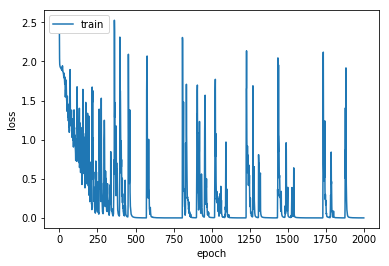

50/50 [==============================] - 0s 7ms/step
acc: 100.00%
('one step prediction : ', ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'd8', 'e8', 'f8', 'g8', 'g8', 'g4', 'g8', 'e8', 'e8', 'e8', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4', 'd8', 'd8', 'd8', 'd8', 'd8', 'e8', 'f4', 'e8', 'e8', 'e8', 'e8', 'e8', 'f8', 'g4', 'g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4'])
('full song prediction : ', ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'd8', 'e8', 'f8', 'g8', 'g8', 'g4', 'g8', 'e8', 'e8', 'e8', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4', 'd8', 'd8', 'd8', 'd8', 'd8', 'e8', 'f4', 'e8', 'e8', 'e8', 'e8', 'e8', 'f8', 'g4', 'g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4'])


In [6]:
# 0. 사용할 패키지 불러오기
import keras
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.utils import np_utils

# 랜덤시드 고정시키기
np.random.seed(5)

# 손실 이력 클래스 정의
class LossHistory(keras.callbacks.Callback):
    def init(self):
        self.losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

# 데이터셋 생성 함수
def seq2dataset(seq, window_size):
    dataset = []
    for i in range(len(seq)-window_size):
        subset = seq[i:(i+window_size+1)]
        dataset.append([code2idx[item] for item in subset])
    return np.array(dataset)        

# 1. 데이터 준비하기

# 코드 사전 정의

code2idx = {'c4':0, 'd4':1, 'e4':2, 'f4':3, 'g4':4, 'a4':5, 'b4':6,
            'c8':7, 'd8':8, 'e8':9, 'f8':10, 'g8':11, 'a8':12, 'b8':13}

idx2code = {0:'c4', 1:'d4', 2:'e4', 3:'f4', 4:'g4', 5:'a4', 6:'b4',
            7:'c8', 8:'d8', 9:'e8', 10:'f8', 11:'g8', 12:'a8', 13:'b8'}

# 시퀀스 데이터 정의

seq = ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'd8', 'e8', 'f8', 'g8', 'g8', 'g4',
       'g8', 'e8', 'e8', 'e8', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4',
       'd8', 'd8', 'd8', 'd8', 'd8', 'e8', 'f4', 'e8', 'e8', 'e8', 'e8', 'e8', 'f8', 'g4',
       'g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4']

# 2. 데이터셋 생성하기

dataset = seq2dataset(seq, window_size = 4)

print(dataset.shape)

# 입력(X)과 출력(Y) 변수로 분리하기
x_train = dataset[:,0:4]
y_train = dataset[:,4]

max_idx_value = 13

# 입력값 정규화 시키기
x_train = x_train / float(max_idx_value)

# 입력을 (샘플 수, 타임스텝, 특성 수)로 형태 변환
x_train = np.reshape(x_train, (50, 4, 1))

# 라벨값에 대한 one-hot 인코딩 수행
y_train = np_utils.to_categorical(y_train)

one_hot_vec_size = y_train.shape[1]

print("one hot encoding vector size is ", one_hot_vec_size)

# 3. 모델 구성하기
model = Sequential()
model.add(LSTM(128, batch_input_shape = (1, 4, 1), stateful=True))
model.add(Dense(one_hot_vec_size, activation='softmax'))
    
# 4. 모델 학습과정 설정하기
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 5. 모델 학습시키기
num_epochs = 2000

history = LossHistory() # 손실 이력 객체 생성

history.init()

# 상태 초기화
for epoch_idx in range(num_epochs):
    print ('epochs : ' + str(epoch_idx) )
    model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2, shuffle=False, callbacks=[history]) # 50 is X.shape[0]
    model.reset_states()
    
# 6. 학습과정 살펴보기
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(history.losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

# 7. 모델 평가하기
scores = model.evaluate(x_train, y_train, batch_size=1)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))
model.reset_states()

# 8. 모델 사용하기

pred_count = 50 # 최대 예측 개수 정의

# 한 스텝 예측

seq_out = ['g8', 'e8', 'e4', 'f8']
pred_out = model.predict(x_train, batch_size=1)

for i in range(pred_count):
    idx = np.argmax(pred_out[i]) # one-hot 인코딩을 인덱스 값으로 변환
    seq_out.append(idx2code[idx]) # seq_out는 최종 악보이므로 인덱스 값을 코드로 변환하여 저장

model.reset_states()
    
print("one step prediction : ", seq_out)

# 곡 전체 예측

seq_in = ['g8', 'e8', 'e4', 'f8']
seq_out = seq_in
seq_in = [code2idx[it] / float(max_idx_value) for it in seq_in] # 코드를 인덱스값으로 변환

for i in range(pred_count):
    sample_in = np.array(seq_in)
    sample_in = np.reshape(sample_in, (1, 4, 1)) # 샘플 수, 타입스텝 수, 속성 수
    pred_out = model.predict(sample_in)
    idx = np.argmax(pred_out)
    seq_out.append(idx2code[idx])
    seq_in.append(idx / float(max_idx_value))
    seq_in.pop(0)

model.reset_states()
    
print("full song prediction : ", seq_out)

상태유지 LSTM은 음표를 모두 맞췄고, 전체 곡 예측도 정확하게 예측하였다.

### 8. 입력 속성이 여러 개인 모델 구성
예를 들어 설명해보겠다. 기온이라는 것을 예측하기 위해서는 입력으로 기온뿐만 아니라 습도, 기압, 풍속 등 다양한 속성들이 있다.<br>
상태유지 LSTM 모델에서 입력형태를 batch_input_shape = (배치사이즈, 타임스텝, 속성)로 설정하는데 마지막 인자가 **속성의 개수**가 지정한다.<br>
현재 입력값이 'c4, e4, g8'등으로 되어 있는데 이를 음정과 음길이로 나누어서 2개의 속성으로 입력한다.<br>
즉 'c4'로 나누어서 (c,4)로 나누어서 입력하게 된다. 아래처럼 코드를 짜면 된다.<br>

    def code2features(code):
        features = []
        features.append(code2scale[code[0]]/float(max_scale_value))
        features.append(code2length[code[1]])
        return features
        
LSTM 모델 생성 시 batch_input_shape 인자의 마지막 값이 1에서 2로 수정된다.(p.171 참고)<br>

    model = Sequential() 
    model.add(LSTM(128, batch_input_shape = (1, 4, 2), stateful=True))
    model.add(Dense(one_hot_vec_size, activation='softmax'))
    
이 방법은 코드 자체를 학습하는 것이 아니라 음정과 음길이를 나누어서 학습하는 효과라고 할 수 있다.<br>
즉 사람이 악보를 읽을 때 이 둘을 나누어서 학습하므로 사람에 가까운 학습이라고 할 수 있다.

('one hot encoding vector size is ', 12)
epochs : 0
Epoch 1/1
 - 1s - loss: 2.3061 - acc: 0.1400
epochs : 1
Epoch 1/1
 - 0s - loss: 2.0180 - acc: 0.3400
epochs : 2
Epoch 1/1
 - 0s - loss: 1.9620 - acc: 0.3400
epochs : 3
Epoch 1/1
 - 0s - loss: 1.9461 - acc: 0.3400
epochs : 4
Epoch 1/1
 - 0s - loss: 1.9359 - acc: 0.3400
epochs : 5
Epoch 1/1
 - 0s - loss: 1.9284 - acc: 0.3400
epochs : 6
Epoch 1/1
 - 0s - loss: 1.9224 - acc: 0.3400
epochs : 7
Epoch 1/1
 - 0s - loss: 1.9172 - acc: 0.3400
epochs : 8
Epoch 1/1
 - 0s - loss: 1.9123 - acc: 0.3600
epochs : 9
Epoch 1/1
 - 0s - loss: 1.9074 - acc: 0.3600
epochs : 10
Epoch 1/1
 - 0s - loss: 1.9019 - acc: 0.3600
epochs : 11
Epoch 1/1
 - 0s - loss: 1.8946 - acc: 0.3600
epochs : 12
Epoch 1/1
 - 0s - loss: 1.8826 - acc: 0.3600
epochs : 13
Epoch 1/1
 - 0s - loss: 1.8686 - acc: 0.3600
epochs : 14
Epoch 1/1
 - 0s - loss: 1.8542 - acc: 0.3600
epochs : 15
Epoch 1/1
 - 0s - loss: 1.8405 - acc: 0.3600
epochs : 16
Epoch 1/1
 - 0s - loss: 1.8168 - acc: 0.3600


epochs : 143
Epoch 1/1
 - 0s - loss: 0.0097 - acc: 1.0000
epochs : 144
Epoch 1/1
 - 0s - loss: 0.0094 - acc: 1.0000
epochs : 145
Epoch 1/1
 - 0s - loss: 0.0089 - acc: 1.0000
epochs : 146
Epoch 1/1
 - 0s - loss: 0.0084 - acc: 1.0000
epochs : 147
Epoch 1/1
 - 0s - loss: 0.0079 - acc: 1.0000
epochs : 148
Epoch 1/1
 - 0s - loss: 0.0075 - acc: 1.0000
epochs : 149
Epoch 1/1
 - 0s - loss: 0.0073 - acc: 1.0000
epochs : 150
Epoch 1/1
 - 0s - loss: 0.0069 - acc: 1.0000
epochs : 151
Epoch 1/1
 - 0s - loss: 0.0064 - acc: 1.0000
epochs : 152
Epoch 1/1
 - 0s - loss: 0.0060 - acc: 1.0000
epochs : 153
Epoch 1/1
 - 0s - loss: 0.0057 - acc: 1.0000
epochs : 154
Epoch 1/1
 - 0s - loss: 0.0054 - acc: 1.0000
epochs : 155
Epoch 1/1
 - 0s - loss: 0.0052 - acc: 1.0000
epochs : 156
Epoch 1/1
 - 0s - loss: 0.0049 - acc: 1.0000
epochs : 157
Epoch 1/1
 - 0s - loss: 0.0047 - acc: 1.0000
epochs : 158
Epoch 1/1
 - 0s - loss: 0.0046 - acc: 1.0000
epochs : 159
Epoch 1/1
 - 0s - loss: 0.0044 - acc: 1.0000
epochs : 160
E

 - 0s - loss: 0.0013 - acc: 1.0000
epochs : 285
Epoch 1/1
 - 0s - loss: 0.0012 - acc: 1.0000
epochs : 286
Epoch 1/1
 - 0s - loss: 0.0012 - acc: 1.0000
epochs : 287
Epoch 1/1
 - 0s - loss: 0.0012 - acc: 1.0000
epochs : 288
Epoch 1/1
 - 0s - loss: 0.0011 - acc: 1.0000
epochs : 289
Epoch 1/1
 - 0s - loss: 0.0011 - acc: 1.0000
epochs : 290
Epoch 1/1
 - 0s - loss: 0.0011 - acc: 1.0000
epochs : 291
Epoch 1/1
 - 0s - loss: 0.0011 - acc: 1.0000
epochs : 292
Epoch 1/1
 - 0s - loss: 0.0010 - acc: 1.0000
epochs : 293
Epoch 1/1
 - 0s - loss: 0.0010 - acc: 1.0000
epochs : 294
Epoch 1/1
 - 0s - loss: 9.9579e-04 - acc: 1.0000
epochs : 295
Epoch 1/1
 - 0s - loss: 9.8053e-04 - acc: 1.0000
epochs : 296
Epoch 1/1
 - 0s - loss: 9.6674e-04 - acc: 1.0000
epochs : 297
Epoch 1/1
 - 0s - loss: 9.5582e-04 - acc: 1.0000
epochs : 298
Epoch 1/1
 - 0s - loss: 9.4602e-04 - acc: 1.0000
epochs : 299
Epoch 1/1
 - 0s - loss: 9.3452e-04 - acc: 1.0000
epochs : 300
Epoch 1/1
 - 0s - loss: 9.2229e-04 - acc: 1.0000
epochs : 

epochs : 424
Epoch 1/1
 - 0s - loss: 7.4365e-04 - acc: 1.0000
epochs : 425
Epoch 1/1
 - 0s - loss: 7.1446e-04 - acc: 1.0000
epochs : 426
Epoch 1/1
 - 0s - loss: 6.8090e-04 - acc: 1.0000
epochs : 427
Epoch 1/1
 - 0s - loss: 6.5558e-04 - acc: 1.0000
epochs : 428
Epoch 1/1
 - 0s - loss: 6.3005e-04 - acc: 1.0000
epochs : 429
Epoch 1/1
 - 0s - loss: 6.0712e-04 - acc: 1.0000
epochs : 430
Epoch 1/1
 - 0s - loss: 5.8509e-04 - acc: 1.0000
epochs : 431
Epoch 1/1
 - 0s - loss: 5.6333e-04 - acc: 1.0000
epochs : 432
Epoch 1/1
 - 0s - loss: 5.4176e-04 - acc: 1.0000
epochs : 433
Epoch 1/1
 - 0s - loss: 5.2476e-04 - acc: 1.0000
epochs : 434
Epoch 1/1
 - 0s - loss: 5.1068e-04 - acc: 1.0000
epochs : 435
Epoch 1/1
 - 0s - loss: 5.0838e-04 - acc: 1.0000
epochs : 436
Epoch 1/1
 - 0s - loss: 5.3441e-04 - acc: 1.0000
epochs : 437
Epoch 1/1
 - 0s - loss: 7.0776e-04 - acc: 1.0000
epochs : 438
Epoch 1/1
 - 0s - loss: 0.0018 - acc: 1.0000
epochs : 439
Epoch 1/1
 - 0s - loss: 0.0015 - acc: 1.0000
epochs : 440
Epo

epochs : 561
Epoch 1/1
 - 0s - loss: 2.3218e-04 - acc: 1.0000
epochs : 562
Epoch 1/1
 - 0s - loss: 2.2833e-04 - acc: 1.0000
epochs : 563
Epoch 1/1
 - 0s - loss: 2.2528e-04 - acc: 1.0000
epochs : 564
Epoch 1/1
 - 0s - loss: 2.2363e-04 - acc: 1.0000
epochs : 565
Epoch 1/1
 - 0s - loss: 2.2884e-04 - acc: 1.0000
epochs : 566
Epoch 1/1
 - 0s - loss: 2.5217e-04 - acc: 1.0000
epochs : 567
Epoch 1/1
 - 0s - loss: 2.4645e-04 - acc: 1.0000
epochs : 568
Epoch 1/1
 - 0s - loss: 3.7148e-04 - acc: 1.0000
epochs : 569
Epoch 1/1
 - 0s - loss: 2.5938e-04 - acc: 1.0000
epochs : 570
Epoch 1/1
 - 0s - loss: 2.1288e-04 - acc: 1.0000
epochs : 571
Epoch 1/1
 - 0s - loss: 2.0000e-04 - acc: 1.0000
epochs : 572
Epoch 1/1
 - 0s - loss: 1.8797e-04 - acc: 1.0000
epochs : 573
Epoch 1/1
 - 0s - loss: 1.7991e-04 - acc: 1.0000
epochs : 574
Epoch 1/1
 - 0s - loss: 1.7370e-04 - acc: 1.0000
epochs : 575
Epoch 1/1
 - 0s - loss: 1.6830e-04 - acc: 1.0000
epochs : 576
Epoch 1/1
 - 0s - loss: 1.6392e-04 - acc: 1.0000
epochs :

epochs : 694
Epoch 1/1
 - 0s - loss: 0.2089 - acc: 0.9400
epochs : 695
Epoch 1/1
 - 0s - loss: 0.1812 - acc: 0.9200
epochs : 696
Epoch 1/1
 - 0s - loss: 0.1062 - acc: 0.9800
epochs : 697
Epoch 1/1
 - 0s - loss: 0.0320 - acc: 1.0000
epochs : 698
Epoch 1/1
 - 0s - loss: 0.0216 - acc: 1.0000
epochs : 699
Epoch 1/1
 - 0s - loss: 0.0283 - acc: 1.0000
epochs : 700
Epoch 1/1
 - 0s - loss: 0.0293 - acc: 1.0000
epochs : 701
Epoch 1/1
 - 0s - loss: 0.0270 - acc: 1.0000
epochs : 702
Epoch 1/1
 - 0s - loss: 0.0674 - acc: 0.9800
epochs : 703
Epoch 1/1
 - 0s - loss: 0.1125 - acc: 0.9600
epochs : 704
Epoch 1/1
 - 0s - loss: 0.0946 - acc: 0.9600
epochs : 705
Epoch 1/1
 - 0s - loss: 1.1048 - acc: 0.6400
epochs : 706
Epoch 1/1
 - 0s - loss: 0.9187 - acc: 0.7600
epochs : 707
Epoch 1/1
 - 0s - loss: 0.3572 - acc: 0.8600
epochs : 708
Epoch 1/1
 - 0s - loss: 0.2658 - acc: 0.9200
epochs : 709
Epoch 1/1
 - 0s - loss: 0.2686 - acc: 0.9200
epochs : 710
Epoch 1/1
 - 0s - loss: 0.1766 - acc: 0.9400
epochs : 711
E

epochs : 832
Epoch 1/1
 - 0s - loss: 0.1216 - acc: 1.0000
epochs : 833
Epoch 1/1
 - 0s - loss: 0.9088 - acc: 0.7600
epochs : 834
Epoch 1/1
 - 0s - loss: 0.5201 - acc: 0.8200
epochs : 835
Epoch 1/1
 - 0s - loss: 0.3039 - acc: 0.9200
epochs : 836
Epoch 1/1
 - 0s - loss: 0.3934 - acc: 0.8400
epochs : 837
Epoch 1/1
 - 0s - loss: 0.0937 - acc: 0.9600
epochs : 838
Epoch 1/1
 - 0s - loss: 0.2841 - acc: 0.9600
epochs : 839
Epoch 1/1
 - 0s - loss: 0.0620 - acc: 1.0000
epochs : 840
Epoch 1/1
 - 0s - loss: 0.0542 - acc: 1.0000
epochs : 841
Epoch 1/1
 - 0s - loss: 0.0506 - acc: 1.0000
epochs : 842
Epoch 1/1
 - 0s - loss: 0.0294 - acc: 1.0000
epochs : 843
Epoch 1/1
 - 0s - loss: 0.0291 - acc: 1.0000
epochs : 844
Epoch 1/1
 - 0s - loss: 0.0164 - acc: 1.0000
epochs : 845
Epoch 1/1
 - 0s - loss: 0.0121 - acc: 1.0000
epochs : 846
Epoch 1/1
 - 0s - loss: 0.0105 - acc: 1.0000
epochs : 847
Epoch 1/1
 - 0s - loss: 0.0095 - acc: 1.0000
epochs : 848
Epoch 1/1
 - 0s - loss: 0.0086 - acc: 1.0000
epochs : 849
E

 - 0s - loss: 0.0047 - acc: 1.0000
epochs : 971
Epoch 1/1
 - 0s - loss: 0.0044 - acc: 1.0000
epochs : 972
Epoch 1/1
 - 0s - loss: 0.0042 - acc: 1.0000
epochs : 973
Epoch 1/1
 - 0s - loss: 0.0039 - acc: 1.0000
epochs : 974
Epoch 1/1
 - 0s - loss: 0.0037 - acc: 1.0000
epochs : 975
Epoch 1/1
 - 0s - loss: 0.0035 - acc: 1.0000
epochs : 976
Epoch 1/1
 - 0s - loss: 0.0033 - acc: 1.0000
epochs : 977
Epoch 1/1
 - 0s - loss: 0.0032 - acc: 1.0000
epochs : 978
Epoch 1/1
 - 0s - loss: 0.0030 - acc: 1.0000
epochs : 979
Epoch 1/1
 - 0s - loss: 0.0029 - acc: 1.0000
epochs : 980
Epoch 1/1
 - 0s - loss: 0.0027 - acc: 1.0000
epochs : 981
Epoch 1/1
 - 0s - loss: 0.0026 - acc: 1.0000
epochs : 982
Epoch 1/1
 - 0s - loss: 0.0025 - acc: 1.0000
epochs : 983
Epoch 1/1
 - 0s - loss: 0.0024 - acc: 1.0000
epochs : 984
Epoch 1/1
 - 0s - loss: 0.0023 - acc: 1.0000
epochs : 985
Epoch 1/1
 - 0s - loss: 0.0022 - acc: 1.0000
epochs : 986
Epoch 1/1
 - 0s - loss: 0.0021 - acc: 1.0000
epochs : 987
Epoch 1/1
 - 0s - loss: 

epochs : 1104
Epoch 1/1
 - 0s - loss: 0.0093 - acc: 1.0000
epochs : 1105
Epoch 1/1
 - 0s - loss: 0.0072 - acc: 1.0000
epochs : 1106
Epoch 1/1
 - 0s - loss: 0.0061 - acc: 1.0000
epochs : 1107
Epoch 1/1
 - 0s - loss: 0.0053 - acc: 1.0000
epochs : 1108
Epoch 1/1
 - 0s - loss: 0.0048 - acc: 1.0000
epochs : 1109
Epoch 1/1
 - 0s - loss: 0.0045 - acc: 1.0000
epochs : 1110
Epoch 1/1
 - 0s - loss: 0.0041 - acc: 1.0000
epochs : 1111
Epoch 1/1
 - 0s - loss: 0.0038 - acc: 1.0000
epochs : 1112
Epoch 1/1
 - 0s - loss: 0.0035 - acc: 1.0000
epochs : 1113
Epoch 1/1
 - 0s - loss: 0.0032 - acc: 1.0000
epochs : 1114
Epoch 1/1
 - 0s - loss: 0.0029 - acc: 1.0000
epochs : 1115
Epoch 1/1
 - 0s - loss: 0.0027 - acc: 1.0000
epochs : 1116
Epoch 1/1
 - 0s - loss: 0.0025 - acc: 1.0000
epochs : 1117
Epoch 1/1
 - 0s - loss: 0.0023 - acc: 1.0000
epochs : 1118
Epoch 1/1
 - 0s - loss: 0.0022 - acc: 1.0000
epochs : 1119
Epoch 1/1
 - 0s - loss: 0.0020 - acc: 1.0000
epochs : 1120
Epoch 1/1
 - 0s - loss: 0.0019 - acc: 1.00

epochs : 1236
Epoch 1/1
 - 0s - loss: 5.5541e-05 - acc: 1.0000
epochs : 1237
Epoch 1/1
 - 0s - loss: 5.4541e-05 - acc: 1.0000
epochs : 1238
Epoch 1/1
 - 0s - loss: 5.3561e-05 - acc: 1.0000
epochs : 1239
Epoch 1/1
 - 0s - loss: 5.2752e-05 - acc: 1.0000
epochs : 1240
Epoch 1/1
 - 0s - loss: 5.1600e-05 - acc: 1.0000
epochs : 1241
Epoch 1/1
 - 0s - loss: 5.0488e-05 - acc: 1.0000
epochs : 1242
Epoch 1/1
 - 0s - loss: 4.9294e-05 - acc: 1.0000
epochs : 1243
Epoch 1/1
 - 0s - loss: 4.8141e-05 - acc: 1.0000
epochs : 1244
Epoch 1/1
 - 0s - loss: 4.6949e-05 - acc: 1.0000
epochs : 1245
Epoch 1/1
 - 0s - loss: 4.5801e-05 - acc: 1.0000
epochs : 1246
Epoch 1/1
 - 0s - loss: 4.4674e-05 - acc: 1.0000
epochs : 1247
Epoch 1/1
 - 0s - loss: 4.3665e-05 - acc: 1.0000
epochs : 1248
Epoch 1/1
 - 0s - loss: 4.2649e-05 - acc: 1.0000
epochs : 1249
Epoch 1/1
 - 0s - loss: 4.1745e-05 - acc: 1.0000
epochs : 1250
Epoch 1/1
 - 0s - loss: 4.0982e-05 - acc: 1.0000
epochs : 1251
Epoch 1/1
 - 0s - loss: 4.0236e-05 - acc:

 - 0s - loss: 2.0635e-06 - acc: 1.0000
epochs : 1367
Epoch 1/1
 - 0s - loss: 2.0170e-06 - acc: 1.0000
epochs : 1368
Epoch 1/1
 - 0s - loss: 1.9670e-06 - acc: 1.0000
epochs : 1369
Epoch 1/1
 - 0s - loss: 1.9193e-06 - acc: 1.0000
epochs : 1370
Epoch 1/1
 - 0s - loss: 1.8704e-06 - acc: 1.0000
epochs : 1371
Epoch 1/1
 - 0s - loss: 1.8251e-06 - acc: 1.0000
epochs : 1372
Epoch 1/1
 - 0s - loss: 1.7822e-06 - acc: 1.0000
epochs : 1373
Epoch 1/1
 - 0s - loss: 1.7464e-06 - acc: 1.0000
epochs : 1374
Epoch 1/1
 - 0s - loss: 1.7035e-06 - acc: 1.0000
epochs : 1375
Epoch 1/1
 - 0s - loss: 1.6558e-06 - acc: 1.0000
epochs : 1376
Epoch 1/1
 - 0s - loss: 1.6177e-06 - acc: 1.0000
epochs : 1377
Epoch 1/1
 - 0s - loss: 1.5831e-06 - acc: 1.0000
epochs : 1378
Epoch 1/1
 - 0s - loss: 1.5473e-06 - acc: 1.0000
epochs : 1379
Epoch 1/1
 - 0s - loss: 1.5104e-06 - acc: 1.0000
epochs : 1380
Epoch 1/1
 - 0s - loss: 1.4794e-06 - acc: 1.0000
epochs : 1381
Epoch 1/1
 - 0s - loss: 1.4591e-06 - acc: 1.0000
epochs : 1382
Ep

epochs : 1500
Epoch 1/1
 - 0s - loss: 2.3506e-04 - acc: 1.0000
epochs : 1501
Epoch 1/1
 - 0s - loss: 2.2821e-04 - acc: 1.0000
epochs : 1502
Epoch 1/1
 - 0s - loss: 2.2158e-04 - acc: 1.0000
epochs : 1503
Epoch 1/1
 - 0s - loss: 2.1533e-04 - acc: 1.0000
epochs : 1504
Epoch 1/1
 - 0s - loss: 2.0935e-04 - acc: 1.0000
epochs : 1505
Epoch 1/1
 - 0s - loss: 2.0310e-04 - acc: 1.0000
epochs : 1506
Epoch 1/1
 - 0s - loss: 1.9723e-04 - acc: 1.0000
epochs : 1507
Epoch 1/1
 - 0s - loss: 1.9162e-04 - acc: 1.0000
epochs : 1508
Epoch 1/1
 - 0s - loss: 1.8620e-04 - acc: 1.0000
epochs : 1509
Epoch 1/1
 - 0s - loss: 1.8060e-04 - acc: 1.0000
epochs : 1510
Epoch 1/1
 - 0s - loss: 1.7600e-04 - acc: 1.0000
epochs : 1511
Epoch 1/1
 - 0s - loss: 1.7145e-04 - acc: 1.0000
epochs : 1512
Epoch 1/1
 - 0s - loss: 1.6727e-04 - acc: 1.0000
epochs : 1513
Epoch 1/1
 - 0s - loss: 1.6363e-04 - acc: 1.0000
epochs : 1514
Epoch 1/1
 - 0s - loss: 1.6017e-04 - acc: 1.0000
epochs : 1515
Epoch 1/1
 - 0s - loss: 1.5652e-04 - acc:

 - 0s - loss: 6.8948e-04 - acc: 1.0000
epochs : 1635
Epoch 1/1
 - 0s - loss: 6.6477e-04 - acc: 1.0000
epochs : 1636
Epoch 1/1
 - 0s - loss: 6.4143e-04 - acc: 1.0000
epochs : 1637
Epoch 1/1
 - 0s - loss: 6.1712e-04 - acc: 1.0000
epochs : 1638
Epoch 1/1
 - 0s - loss: 5.9564e-04 - acc: 1.0000
epochs : 1639
Epoch 1/1
 - 0s - loss: 5.7471e-04 - acc: 1.0000
epochs : 1640
Epoch 1/1
 - 0s - loss: 5.5479e-04 - acc: 1.0000
epochs : 1641
Epoch 1/1
 - 0s - loss: 5.3594e-04 - acc: 1.0000
epochs : 1642
Epoch 1/1
 - 0s - loss: 5.1821e-04 - acc: 1.0000
epochs : 1643
Epoch 1/1
 - 0s - loss: 5.0172e-04 - acc: 1.0000
epochs : 1644
Epoch 1/1
 - 0s - loss: 4.8626e-04 - acc: 1.0000
epochs : 1645
Epoch 1/1
 - 0s - loss: 4.7150e-04 - acc: 1.0000
epochs : 1646
Epoch 1/1
 - 0s - loss: 4.5761e-04 - acc: 1.0000
epochs : 1647
Epoch 1/1
 - 0s - loss: 4.4464e-04 - acc: 1.0000
epochs : 1648
Epoch 1/1
 - 0s - loss: 4.3225e-04 - acc: 1.0000
epochs : 1649
Epoch 1/1
 - 0s - loss: 4.2062e-04 - acc: 1.0000
epochs : 1650
Ep

epochs : 1765
Epoch 1/1
 - 0s - loss: 2.3512e-05 - acc: 1.0000
epochs : 1766
Epoch 1/1
 - 0s - loss: 2.2923e-05 - acc: 1.0000
epochs : 1767
Epoch 1/1
 - 0s - loss: 2.2239e-05 - acc: 1.0000
epochs : 1768
Epoch 1/1
 - 0s - loss: 2.1338e-05 - acc: 1.0000
epochs : 1769
Epoch 1/1
 - 0s - loss: 2.0340e-05 - acc: 1.0000
epochs : 1770
Epoch 1/1
 - 0s - loss: 2.1053e-05 - acc: 1.0000
epochs : 1771
Epoch 1/1
 - 0s - loss: 2.1191e-05 - acc: 1.0000
epochs : 1772
Epoch 1/1
 - 0s - loss: 2.0171e-05 - acc: 1.0000
epochs : 1773
Epoch 1/1
 - 0s - loss: 1.9585e-05 - acc: 1.0000
epochs : 1774
Epoch 1/1
 - 0s - loss: 1.8367e-05 - acc: 1.0000
epochs : 1775
Epoch 1/1
 - 0s - loss: 1.7232e-05 - acc: 1.0000
epochs : 1776
Epoch 1/1
 - 0s - loss: 1.6662e-05 - acc: 1.0000
epochs : 1777
Epoch 1/1
 - 0s - loss: 1.5794e-05 - acc: 1.0000
epochs : 1778
Epoch 1/1
 - 0s - loss: 2.6691e-05 - acc: 1.0000
epochs : 1779
Epoch 1/1
 - 0s - loss: 1.8044e-05 - acc: 1.0000
epochs : 1780
Epoch 1/1
 - 0s - loss: 1.8232e-05 - acc:

 - 0s - loss: 0.6506 - acc: 0.7200
epochs : 1896
Epoch 1/1
 - 0s - loss: 0.4554 - acc: 0.8800
epochs : 1897
Epoch 1/1
 - 0s - loss: 0.2663 - acc: 0.8800
epochs : 1898
Epoch 1/1
 - 0s - loss: 0.7146 - acc: 0.7000
epochs : 1899
Epoch 1/1
 - 0s - loss: 0.0881 - acc: 0.9800
epochs : 1900
Epoch 1/1
 - 0s - loss: 0.0422 - acc: 1.0000
epochs : 1901
Epoch 1/1
 - 0s - loss: 0.0192 - acc: 1.0000
epochs : 1902
Epoch 1/1
 - 0s - loss: 0.0136 - acc: 1.0000
epochs : 1903
Epoch 1/1
 - 0s - loss: 0.0097 - acc: 1.0000
epochs : 1904
Epoch 1/1
 - 0s - loss: 0.0077 - acc: 1.0000
epochs : 1905
Epoch 1/1
 - 0s - loss: 0.0065 - acc: 1.0000
epochs : 1906
Epoch 1/1
 - 0s - loss: 0.0058 - acc: 1.0000
epochs : 1907
Epoch 1/1
 - 0s - loss: 0.0053 - acc: 1.0000
epochs : 1908
Epoch 1/1
 - 0s - loss: 0.0048 - acc: 1.0000
epochs : 1909
Epoch 1/1
 - 0s - loss: 0.0045 - acc: 1.0000
epochs : 1910
Epoch 1/1
 - 0s - loss: 0.0041 - acc: 1.0000
epochs : 1911
Epoch 1/1
 - 0s - loss: 0.0038 - acc: 1.0000
epochs : 1912
Epoch 1

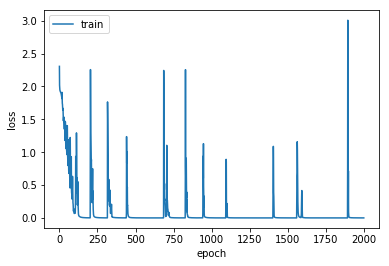

50/50 [==============================] - 0s 7ms/step
acc: 100.00%
('one step prediction : ', ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'd8', 'e8', 'f8', 'g8', 'g8', 'g4', 'g8', 'e8', 'e8', 'e8', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4', 'd8', 'd8', 'd8', 'd8', 'd8', 'e8', 'f4', 'e8', 'e8', 'e8', 'e8', 'e8', 'f8', 'g4', 'g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4'])
('full song prediction : ', ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'd8', 'e8', 'f8', 'g8', 'g8', 'g4', 'g8', 'e8', 'e8', 'e8', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4', 'd8', 'd8', 'd8', 'd8', 'd8', 'e8', 'f4', 'e8', 'e8', 'e8', 'e8', 'e8', 'f8', 'g4', 'g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4'])


In [7]:
# 0. 사용할 패키지 불러오기
import keras
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.utils import np_utils

# 랜덤시드 고정시키기
np.random.seed(5)

# 손실 이력 클래스 정의
class LossHistory(keras.callbacks.Callback):
    def init(self):
        self.losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

# 데이터셋 생성 함수
def seq2dataset(seq, window_size):
    dataset_X = []
    dataset_Y = []
    
    for i in range(len(seq)-window_size):
        
        subset = seq[i:(i+window_size+1)]
        
        for si in range(len(subset)-1):
            features = code2features(subset[si])            
            dataset_X.append(features)

        dataset_Y.append([code2idx[subset[window_size]]])
        
    return np.array(dataset_X), np.array(dataset_Y)

# 속성 변환 함수
def code2features(code):
    features = []
    features.append(code2scale[code[0]]/float(max_scale_value))
    features.append(code2length[code[1]])
    return features

# 1. 데이터 준비하기

# 코드 사전 정의

code2scale = {'c':0, 'd':1, 'e':2, 'f':3, 'g':4, 'a':5, 'b':6}
code2length = {'4':0, '8':1}

code2idx = {'c4':0, 'd4':1, 'e4':2, 'f4':3, 'g4':4, 'a4':5, 'b4':6,
            'c8':7, 'd8':8, 'e8':9, 'f8':10, 'g8':11, 'a8':12, 'b8':13}

idx2code = {0:'c4', 1:'d4', 2:'e4', 3:'f4', 4:'g4', 5:'a4', 6:'b4',
            7:'c8', 8:'d8', 9:'e8', 10:'f8', 11:'g8', 12:'a8', 13:'b8'}

max_scale_value = 6.0
    
# 시퀀스 데이터 정의
seq = ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'd8', 'e8', 'f8', 'g8', 'g8', 'g4',
       'g8', 'e8', 'e8', 'e8', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4',
       'd8', 'd8', 'd8', 'd8', 'd8', 'e8', 'f4', 'e8', 'e8', 'e8', 'e8', 'e8', 'f8', 'g4',
       'g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4']

# 2. 데이터셋 생성하기

x_train, y_train = seq2dataset(seq, window_size = 4)

# 입력을 (샘플 수, 타임스텝, 특성 수)로 형태 변환
x_train = np.reshape(x_train, (50, 4, 2))

# 라벨값에 대한 one-hot 인코딩 수행
y_train = np_utils.to_categorical(y_train)

one_hot_vec_size = y_train.shape[1]

print("one hot encoding vector size is ", one_hot_vec_size)

# 3. 모델 구성하기
model = Sequential()
model.add(LSTM(128, batch_input_shape = (1, 4, 2), stateful=True))
model.add(Dense(one_hot_vec_size, activation='softmax'))
    
# 4. 모델 학습과정 설정하기
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 5. 모델 학습시키기
num_epochs = 2000

history = LossHistory() # 손실 이력 객체 생성
history.init()

for epoch_idx in range(num_epochs):
    print ('epochs : ' + str(epoch_idx) )
    model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2, shuffle=False, callbacks=[history]) # 50 is X.shape[0]
    model.reset_states()
    
# 6. 학습과정 살펴보기
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(history.losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

# 7. 모델 평가하기
scores = model.evaluate(x_train, y_train, batch_size=1)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))
model.reset_states()

# 8. 모델 사용하기

pred_count = 50 # 최대 예측 개수 정의

# 한 스텝 예측

seq_out = ['g8', 'e8', 'e4', 'f8']
pred_out = model.predict(x_train, batch_size=1)

# 상태 초기화
for i in range(pred_count):
    idx = np.argmax(pred_out[i]) # one-hot 인코딩을 인덱스 값으로 변환
    seq_out.append(idx2code[idx]) # seq_out는 최종 악보이므로 인덱스 값을 코드로 변환하여 저장
    
print("one step prediction : ", seq_out)

model.reset_states()

# 곡 전체 예측

seq_in = ['g8', 'e8', 'e4', 'f8']
seq_out = seq_in

seq_in_featrues = []

for si in seq_in:
    features = code2features(si)
    seq_in_featrues.append(features)

for i in range(pred_count):
    sample_in = np.array(seq_in_featrues)
    sample_in = np.reshape(sample_in, (1, 4, 2)) # 샘플 수, 타입스텝 수, 속성 수
    pred_out = model.predict(sample_in)
    idx = np.argmax(pred_out)
    seq_out.append(idx2code[idx])
    
    features = code2features(idx2code[idx])
    seq_in_featrues.append(features)
    seq_in_featrues.pop(0)

model.reset_states()
    
print("full song prediction : ", seq_out)